# Malaria Detection using Deep Learning Techniques

## Table of Contents

- [Implementation](#6)

     - [1 Packages and Libraries](#6.1)
     
     - [2 Exploratory Image Analysis](#6.2)
     
         - [2.1 Read and display samples of Whole Slide Images](#6.2.1)
         
             - [2.1.1 Parasitized Samples](#6.2.1.1)
             
             - [2.2.2 Non-Parasitized Samples](#6.2.2.2)
             
         - [2.2  Data Labelling](#6.2.2)
         
         - [2.3 Image Dimensions](#6.2.3)
         
             - [2.3.1 Parasitized Samples](#6.2.3.1)
             
             - [2.3.2 Non-Parasitized Samples](#6.2.3.2)
             
             - [2.3.3 Summary](#6.2.3.3)
             
         - [2.4 Image Resize](#6.2.4)
         
         - [2.5 Image Color Distribution and Histograms](#6.2.5)
         
             - [2.5.1 Parasitized Samples](#6.2.5.1)
             
             - [2.5.2 Non-Parasitized Samples](#6.2.5.2)
             
         - [2.6 Filtering - Noise Removal](#6.2.6)
         
         - [2.7 Data Augmentation](#6.2.7)
         
             - [2.7.1 Horizontal and Vertical Flip Augmentation](#6.2.7.1)
             
             - [2.7.2 Horizontal and Vertical Shift Augmentation](#6.2.7.2)
             
             - [2.7.3 Random Rotation Augmentation](#6.2.7.3)
             
             - [2.7.4 Random Brightness Augmentation](#6.2.7.4)
             
             - [2.7.5 Random Zoom Augmentation](#6.2.7.5)
             
             - [2.7.6 Random Shear Augmentation](#6.2.7.6)
             
             - [2.7.7 Random Channel Shift Augmentation](#6.2.7.7)
             
         - [2.8 Exploratory Image Analysis - Summary](#6.2.8)
         
     - [3 Model Dataset Creation & Train Test Validation Split](#6.3)
     
         - [3.1 Image Rezise - Train Test Validation ImageSets](#6.3.1)
         
         - [3.2 Label Encoding - Train & Validation](#6.3.2)
         
     - [4 Model Training & Validation](#6.4)
     
         - [4.1 Ensemble Learning - SnapShot Ensembling](#6.4.6)
              
              - [4.1.1 Custom Model ](#4.1.1) 
                  
                  - [4.1.1.1 Custom Ensemble Creation ](#4.1.1.1) 
                  
                  - [4.1.1.2 Custom Snapshots -  Test Metrics ](#4.1.1.2) 
              
              - [4.1.2 EfficientNet - B0 Model ](#4.1.2) 
              
                  - [4.1.2.1 Ensemble Creation ](#4.1.2.1) 
                  
                  - [4.1.2.2 Test Metrics Comparison ](#4.1.2.2)
                  
                  - [4.1.2.3 Test Metrics ](#4.1.2.3) 
                  
                  - [4.1.2.4 Snapshots Test Metrics Comparison ](#4.1.2.4)
                  
                  - [4.1.2.5 Ensemble Test Metrics Comparison ](#4.1.2.5)
             
         - [4.2 Validation Accuracy & Loss - All Models](#4.2)

         - [4.3 Test Evaluation Metrics - All Models](#4.3)

         - [4.4 AUC ROC & AUC PR Curves - All Models](#4.4)
      
     - [5 False Case Analysis](#5)
     
         - [5.1 False Positives](#5.1)
         
         - [5.2 False Negatives](#5.2)
     
     - [6 Summary](#7)
     
         - [6.1 Snapshot Ensemble](#7.1)
         
         - [6.2 False Case Analysis](#7.2)

<a name='6'></a>
# Implementation


<a name='6.1'></a>
## 1 Packages and Libraries

In [1]:
import numpy as np
import pandas as pd
import os
from skimage import io
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
import datetime
import glob
import random as rn
import gc
from collections import Counter

import matplotlib.image as img
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.offline as py
%config InlineBackend.figure_format = 'retina'
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.renderers.default='notebook'

from scipy import stats
from statistics import mean 
from statistics import median 
import seaborn as sns
import cv2

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

import tensorflow as tf

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

# from keras import backend as K
# from keras.backend.tensorflow_backend import set_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import get_session

from IPython.display import Markdown

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Import custom packages and utility files

from DataUtility import dataUtils
dUtils = dataUtils()

from DataUtility import IMAGE_AUGMENTATION_TYPE
from DataUtility import RBC_CELL_TYPE

from ModelTrainer import MalariaNet
MalNetTrainer = MalariaNet()

from MalariaModelBuilder import ModelBuilder
MalNetBuilder = ModelBuilder()

from ModelValidator import ValidateModel
MalNetValidator = ValidateModel()

from CustomImageDataGenerator import CustomDataGenerator
MalNetImageGenerator = CustomDataGenerator()

from GradCamUtility import GradCamUtils
MalNetActivations = GradCamUtils()

from Snapshot_Ensembler import SnapshotEnsemble

<a name='6.2'></a>

# 2 Exploratory Image Analysis

In this section, we will explore the various image pre-processing techniques that can be applied to out dataset and make them ready to be fed to the deep learning systems.

<a name='6.2.1'></a>
### 2.1 Read and display samples of Whole Slide Images

<a name='6.2.1.1'></a>
#### 2.1.1 Parasitized Samples

<br>

***Samples of the Red Blood Cells infected by Malarial Parasites...***

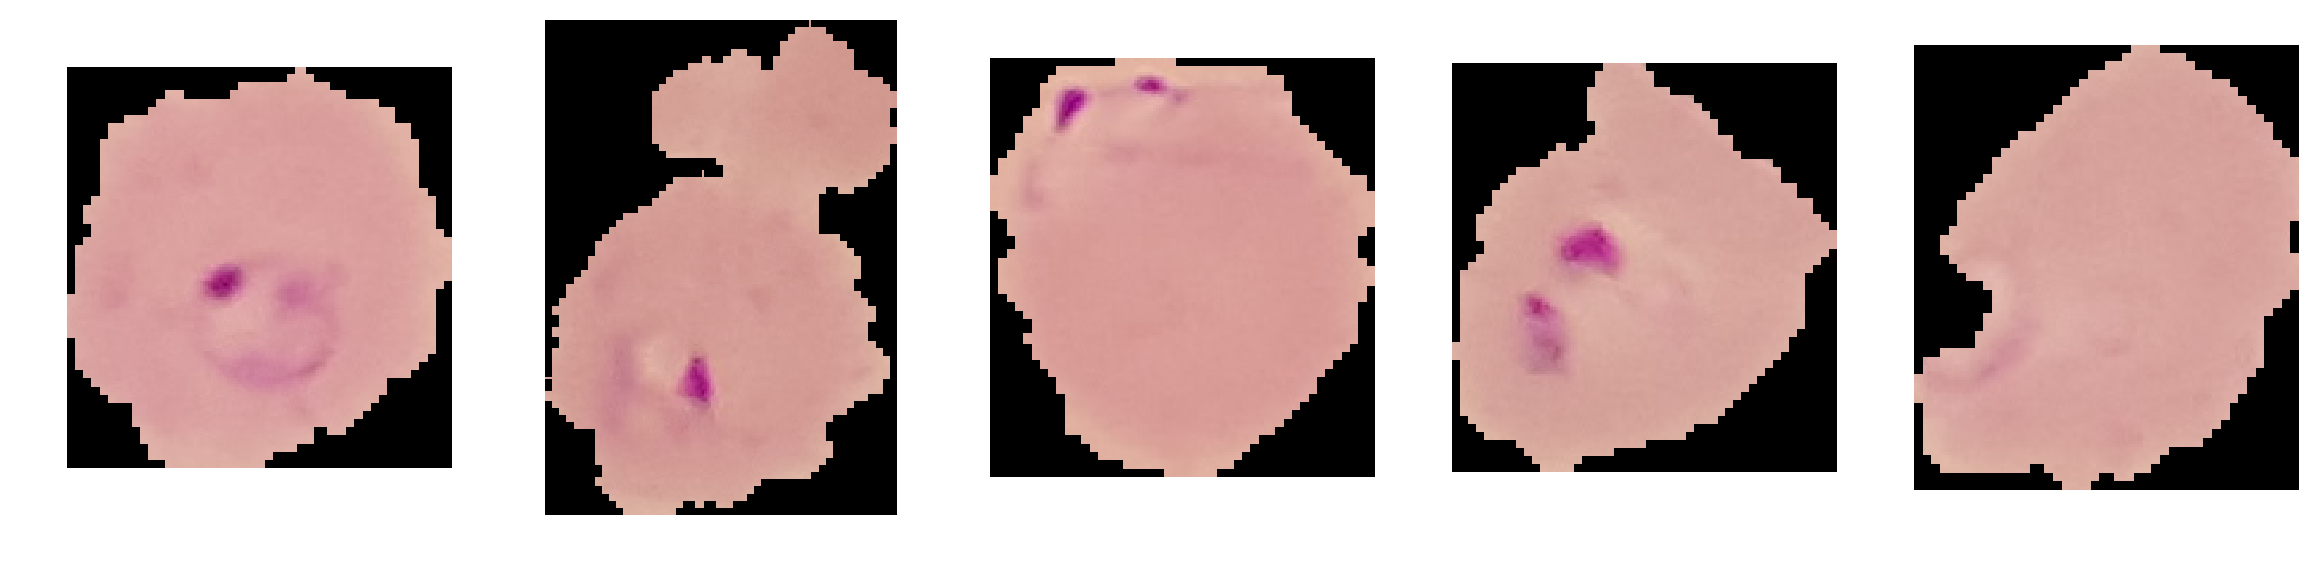

In [3]:
dUtils.PrintMarkdownText('***Samples of the Red Blood Cells infected by Malarial Parasites...***')
dUtils.ReadAndDisplayInputImages(RBC_CELL_TYPE.PARASITIZED.value, 5)

**`As seen in the images above, the parasitized images have a purple colored structure which is the parasite afftected region in the red blood cell. These structures can have a varried shapes and sizes like a ring or oval structure. These ring like structures, their shape, size and the change in color after the staining process helps in determining the parasite species the cell is infected by.`**

<a name='6.2.1.2'></a>
#### 2.1.2 Non-parasitized Samples

<br>

***Samples of the normal Red Blood Cells...***

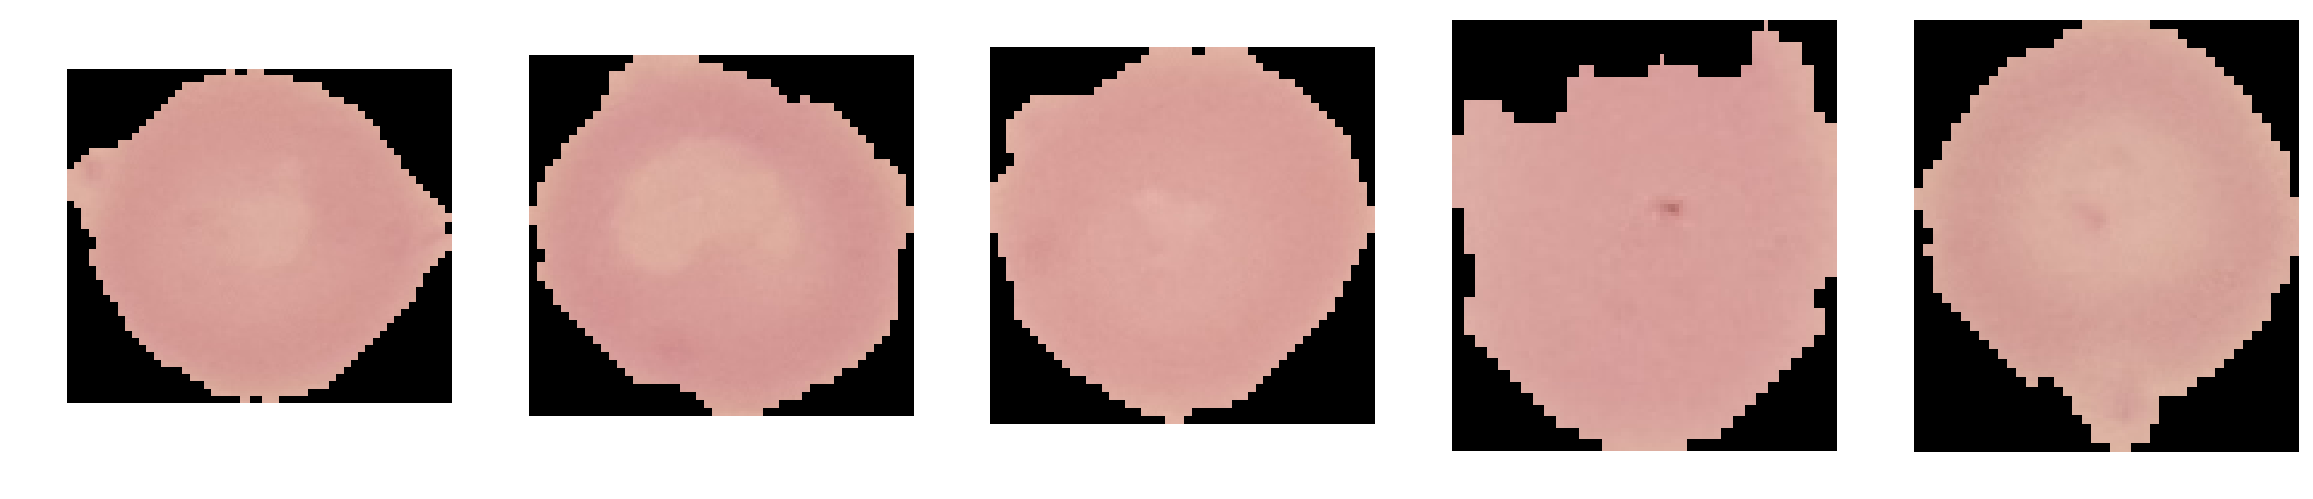

In [4]:
dUtils.PrintMarkdownText('***Samples of the normal Red Blood Cells...***')
dUtils.ReadAndDisplayInputImages(RBC_CELL_TYPE.NONPARASITIZED.value, 5)

<a name='6.2.2'></a>
### 2.2 Data Labelling

The images we have are un-labelled data. Deep learnins systems require proper annotated data to be able to learn the specific representations of each class and perform the job on unseen real time data. So, before proceeding with furtehr analysis we will first assign labels to our data. We have 2 class of images -

1. **Parasitized**

2. **Nonparasitized (or Uninfected)**

Parasitized will be assigned values of 1 and Nonparasitized will be assigned the value 0.

In [3]:
malaria_df = dUtils.GetLabelledMalarialData()

dUtils.PrintMarkdownText('***Labelled malarial images...***')
malaria_df.head()

<br>

***Labelled malarial images...***

filename           label
0  cell_images/Parasitized\C118P79ThinF_IMG_20151...     Parasitized
1  cell_images/Uninfected\C135P96ThinF_IMG_201510...  NonParasitized
2  cell_images/Uninfected\C94P55ThinF_IMG_2015082...  NonParasitized
3  cell_images/Parasitized\C128P89ThinF_IMG_20151...     Parasitized
4  cell_images/Uninfected\C82P43ThinF_IMG_2015081...  NonParasitized

In [6]:
dUtils.PrintMarkdownText('***Annotated malarial dataframe Info...***')
malaria_df.info()

<br>

***Annotated malarial dataframe Info...***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27558 entries, 0 to 27557
Data columns (total 2 columns):
filename    27558 non-null object
label       27558 non-null object
dtypes: object(2)
memory usage: 430.7+ KB


<br>

***Sample Annotated Parasitized & Non-parasitized Images...***

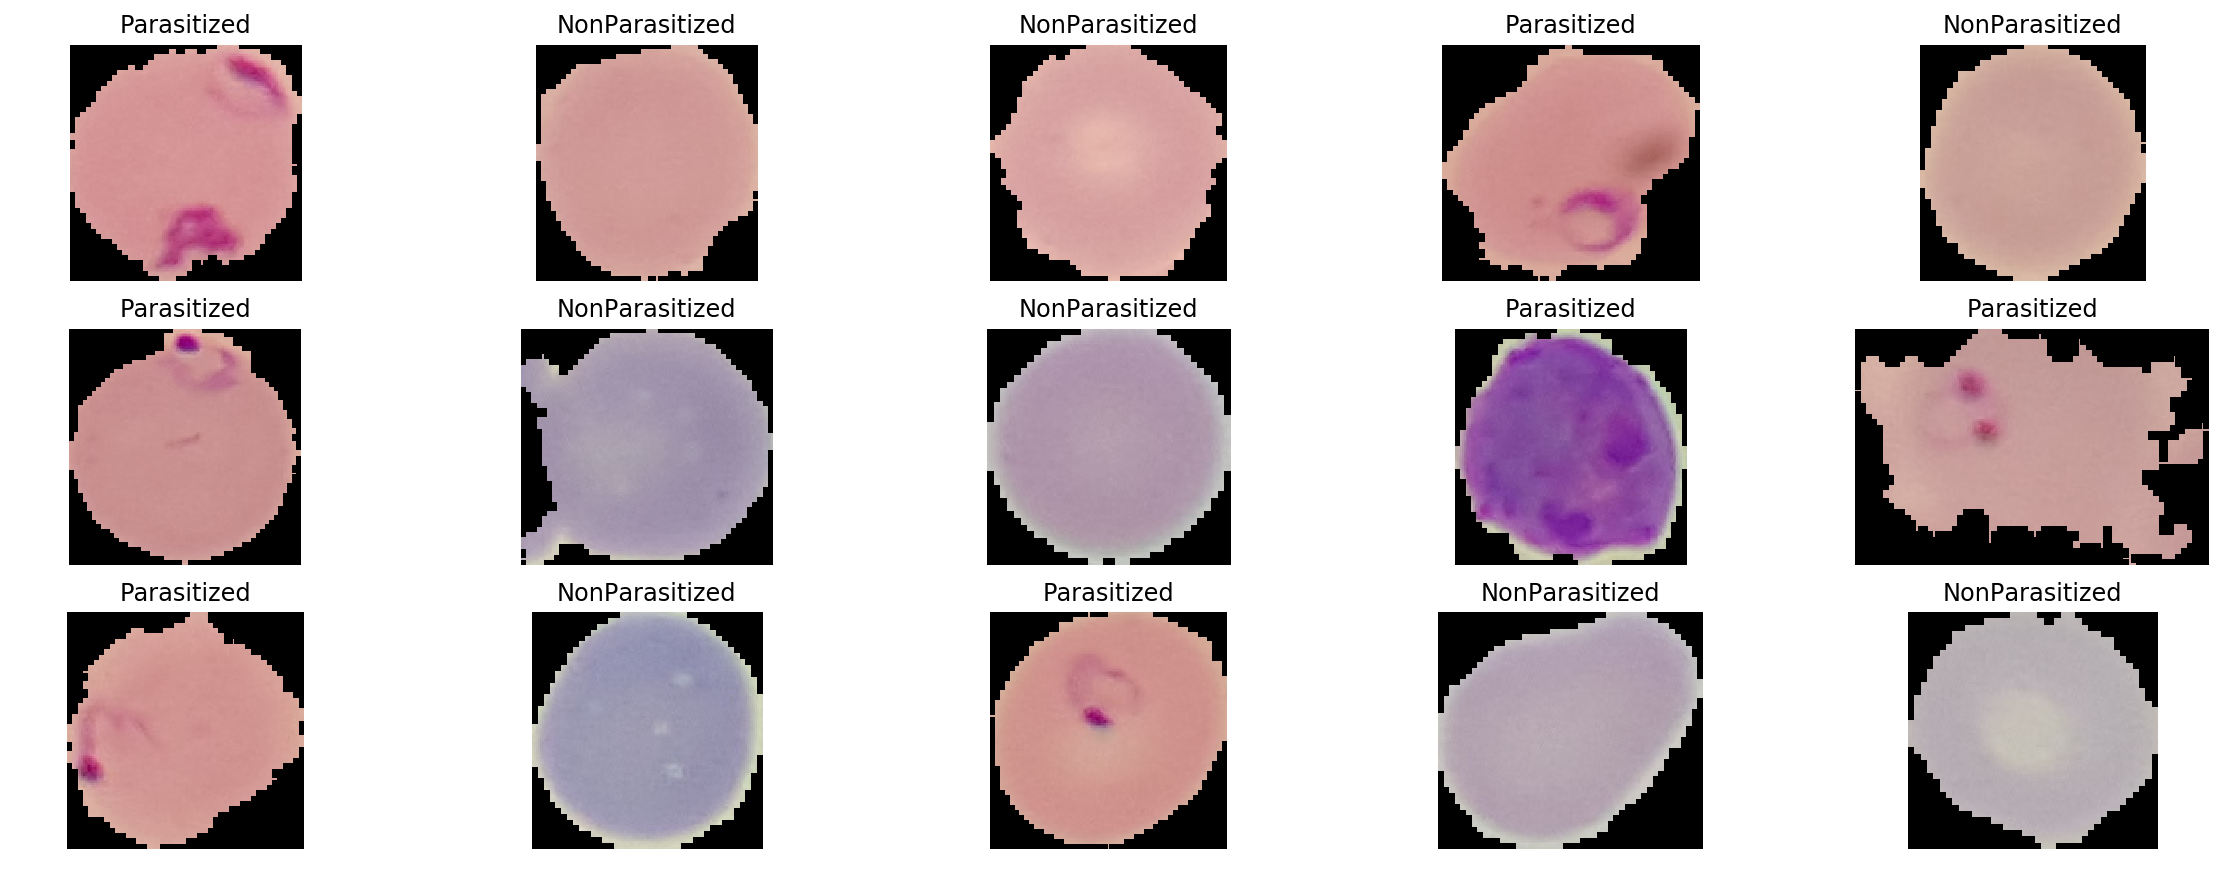

In [7]:
dUtils.PrintMarkdownText('***Sample Annotated Parasitized & Non-parasitized Images...***')
dUtils.DisplayAnnotatedImages(malaria_df, 15)

**Now we have the labels assigned for all the images. As seen the images in both the classes are varrying in dimensions. Lets see the unique sizes of the images we have and the total variations...**
    


<a name='6.2.3'></a>    
### 2.3 Image Dimensions

<a name='6.2.3.1'></a>
#### 2.3.1 Parasitized Samples

In [8]:
# dUtils.PrintMarkdownText('***Shape Distribution for Parasitized Images:***')
# dUtils.ComputeAndPlotImageDimensionalStatistics(RBC_CELL_TYPE.PARASITIZED.value)

<a name='6.2.3.2'></a>
#### 2.3.2 Non-parasitized Samples

In [9]:
# dUtils.PrintMarkdownText('***Shape Distribution for Non-Parasitized Images:***')
# dUtils.ComputeAndPlotImageDimensionalStatistics(RBC_CELL_TYPE.NONPARASITIZED.value)

<a name='6.2.3.3'></a>
***Image Dimensions - SUMMARY :***
    
   So, there are a total of **`1402 unique sized samples`** in the parasitized category & **`1207 unique sized samples`** 
   in the Non-parasitized category. 

   One of the most basic requirement for a smoother model training experience and make the model invariant to varied input
   sizes, resizing is applied such that all the images have a standard size defined for the algorithm. In the context of 
   this study, as seen above the number of uniquely sized images are on the higher side, all the images need to be 
   converted such that they all are of the same dimension. This conversion could be based on the statistical features like 
   the mean or the median size of the images. Lets analyze the statistical distribution of the image size and shape for 
   each category...
   
   Based on the statistical numbers, the size distribution is revolving around the 130 mark for both the parasitized and 
   non-parasitized categories. We will choose **`(135, 135, 3)`** as the common dimension to resize the images.
   
   Below is one example of an image resized to (135, 135, 3).

<a name='6.2.4'></a>

### 2.4 Image Resize - One Sample Image

<br>

***Original vs. Resized Image:***

<Figure size 1440x720 with 0 Axes>

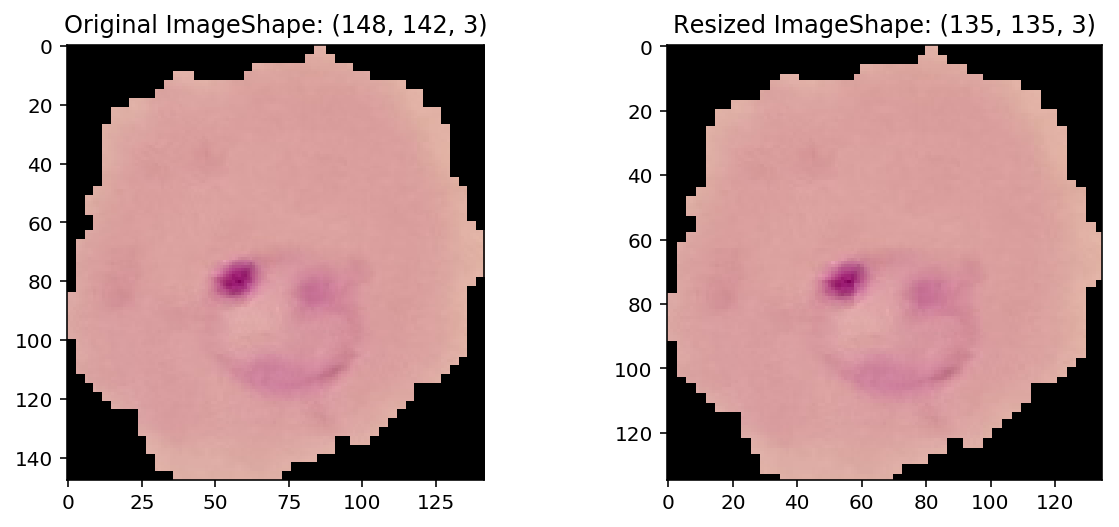

In [10]:
dUtils.PrintMarkdownText('***Original vs. Resized Image:***')

image = dUtils.GetSampleImage(RBC_CELL_TYPE.PARASITIZED.value)
resized_image = cv2.resize(image, (135, 135), interpolation=cv2.INTER_NEAREST)

plt.figure(figsize=(20,10))
f, axes = plt.subplots(1, 2)
f.set_figwidth(10)

# Display the Original and the New Resized Image
axes[0].imshow(image)
axes[1].imshow(resized_image)

axes[0].title.set_text('Original Image' + 'Shape: %s' % (image.shape,))
axes[1].title.set_text('Resized Image' + 'Shape: %s' % (resized_image.shape,))

<a name='6.2.5'></a>

### 2.5 Image Color (RGB) Distribution and Histograms

<a name='6.2.5.1'></a>
#### 2.5.1 Parasitized Samples

<br>

***RGB Color Distribution & Histogram in a sample parasitized image***

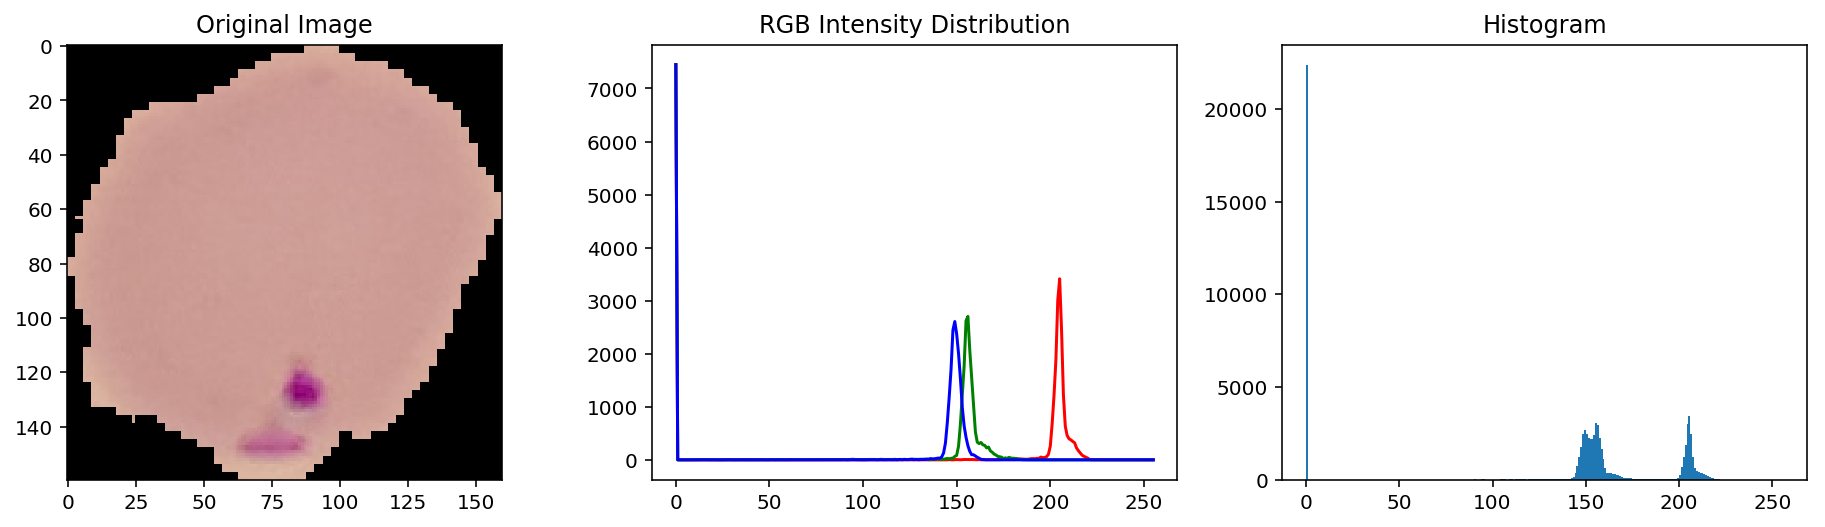

In [11]:
dUtils.PrintMarkdownText("***RGB Color Distribution & Histogram in a sample parasitized image***")
dUtils.PlotImageColorDistribution(RBC_CELL_TYPE.PARASITIZED.value)

<a name='6.2.5.2'></a>
#### 2.5.2 Non-Parasitized Samples

<br>

***RGB Color Distribution & Histogram in a sample non-parasitized image***

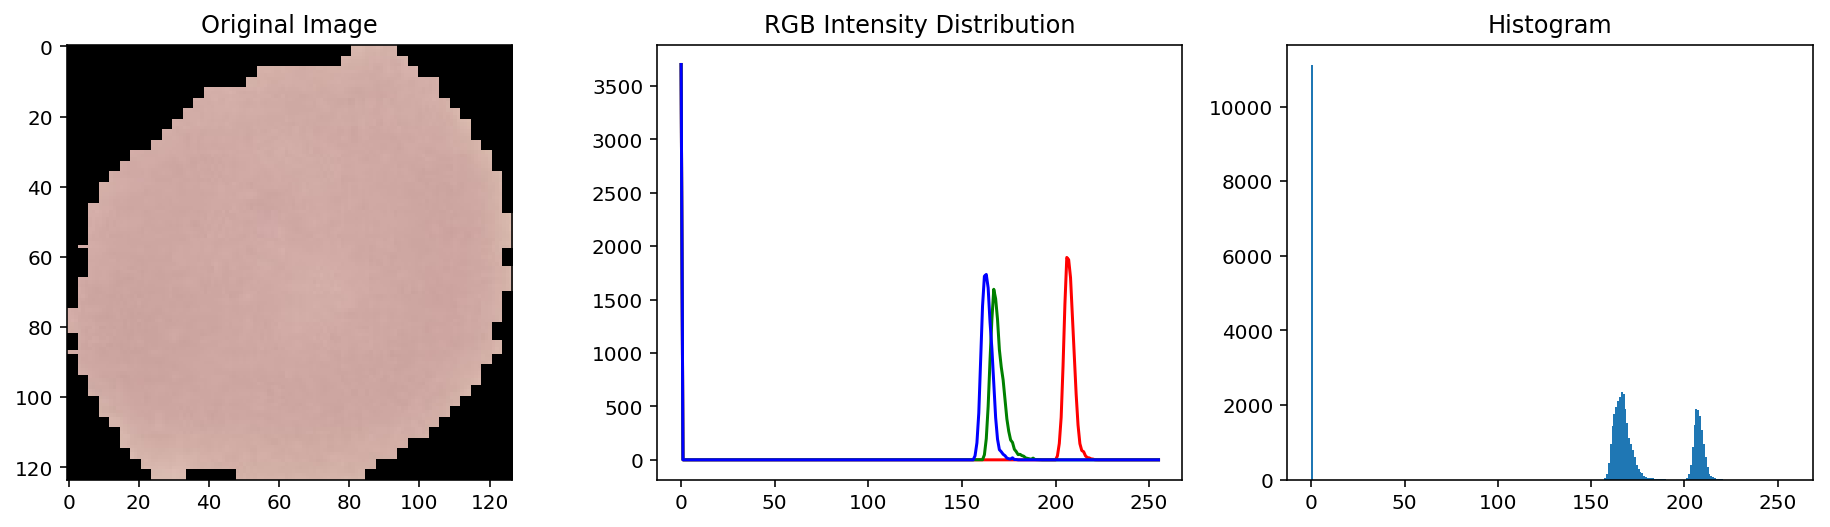

In [12]:
dUtils.PrintMarkdownText("***RGB Color Distribution & Histogram in a sample non-parasitized image***")
dUtils.PlotImageColorDistribution(RBC_CELL_TYPE.NONPARASITIZED.value)

**`As seen for both the parasitized and the non-parasitized cell types, the RGB values are almost on the same intensity levels. Also, the values are around the (140 - 220) range for both the categories.`**

<a name='6.2.6'></a>

### 2.6 Filtering - Noise Removal

***Any random variation that get captured with the image due to uneven lighting conditions, environmental inconsistencies, dust inside the camera can distort and degrade the quality of the image is categorized as noise. Noise is some form is always present in the image (Hambal et al., 2017). The presence of noise in the image could impact a model’s performance. Thus, noise of any kind needs to be removed from the images for an accurate classification.***

We will see the various filetring techniques that are applied for noise removal.

([], <a list of 0 Text yticklabel objects>)

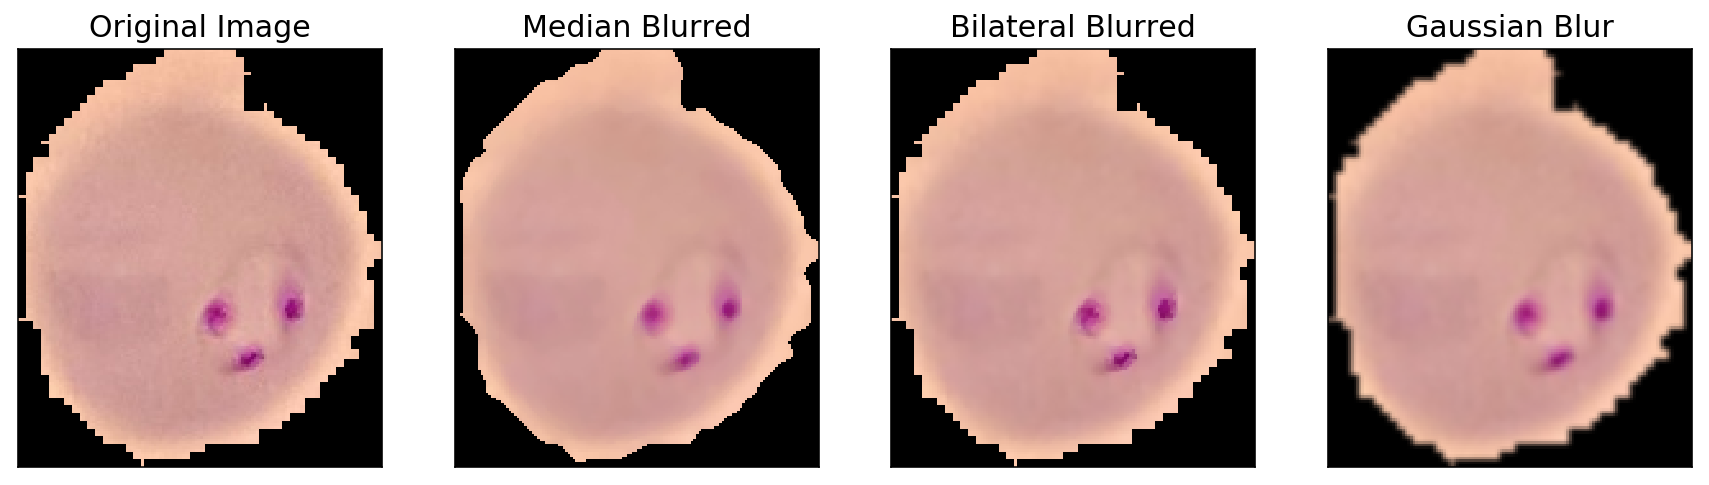

In [13]:
# parasitized = dUtils.GetSampleImage(RBC_CELL_TYPE.PARASITIZED.value)

parasitized = cv2.imread('cell_images/Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png')
parasitized = cv2.cvtColor(parasitized, cv2.COLOR_BGR2RGB)

# Apply various filters...
median_blurr = cv2.medianBlur(parasitized, 5)
bilateral_blurr = cv2.bilateralFilter(parasitized, 5, 25, 25)
gauss_blurr = cv2.GaussianBlur(parasitized,(5,5),0)

plt.figure(figsize=(15, 20))

plt.subplot(141)
plt.imshow(parasitized)
plt.title('Original Image', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(142)
plt.imshow(median_blurr)
plt.title('Median Blurred', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(143)
plt.imshow(bilateral_blurr)
plt.title('Bilateral Blurred', size=15)
plt.xticks([])
plt.yticks([])

plt.subplot(144)
plt.imshow(gauss_blurr)
plt.title('Gaussian Blur', size=15)
plt.xticks([])
plt.yticks([])

**`==> From the above plots, we see that Bilateral filter works well and it preserves the edges too. However, literature survey reveals that the median filtering is the most widely applied technique. So, it remains to be seen which technique will be the better approach for this study.`**

<a name='6.2.7'></a>

### 2.7 Data Augmentation

The term Augmentation refers to making something larger in size. In the context of data, we try to increase the size of the dataset by creating more transformed copies of the original data. This process **`increases the diversity`** in the dataset. Such transformed images help to make the model more robust in handling the real-time images and increase the generalizability of the system. In the context of bio-medical image data, the samples differ from case to case basis. A similar health condition can form a completely different Whole Slide Image. Thus, a deep learning model should be robust enough and be able to generalize on any pattern of the slide image being fed.

In this study, we use the Keras - **`ImageDataGenerator`** module to help with the process of augmentation. The ImageDataGenerator supports various techniques for data augmentation like **`flipping, rotation, cropping, translation, illumination, scaling, adding noise, shift, zooming`**, etc... This enables the model to learn all the variations in these data, increasing the accuracy, robustness and also help to reduce overfitting which often becomes the case with lesser data.

We will see the various augmentation strategies on a sample parasitized red blood cell.

<a name='6.2.7.1'></a>
#### 2.7.1  Horizontal and Vertical Flipping Augmentation

**HORIZONTAL FLIP**

<br>

***Original vs. Augmented Images...***

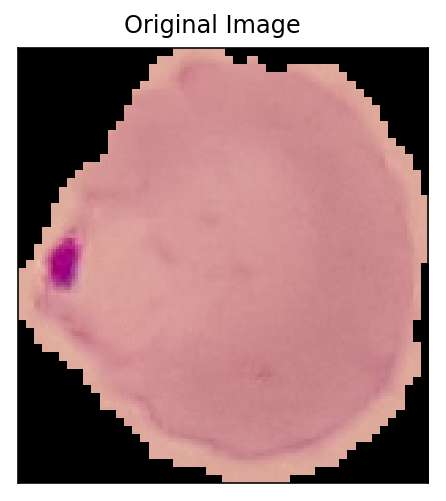

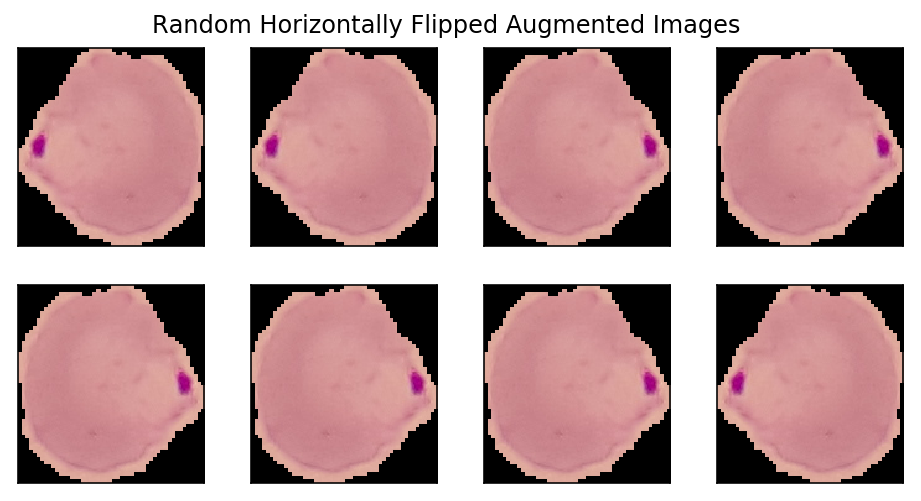

In [14]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.HORIZONTAL_FLIP.value)

**VERTICAL FLIP**

<br>

***Original vs. Augmented Images...***

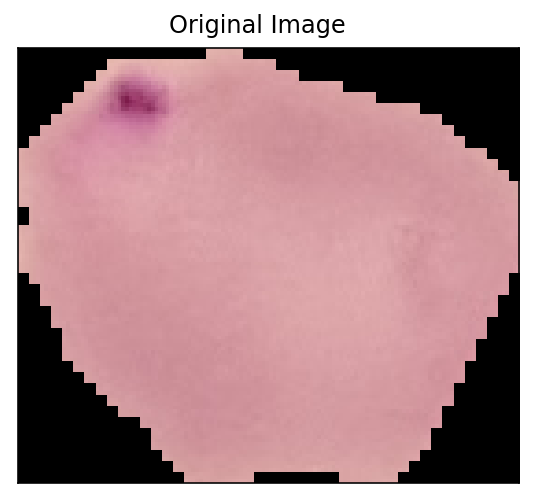

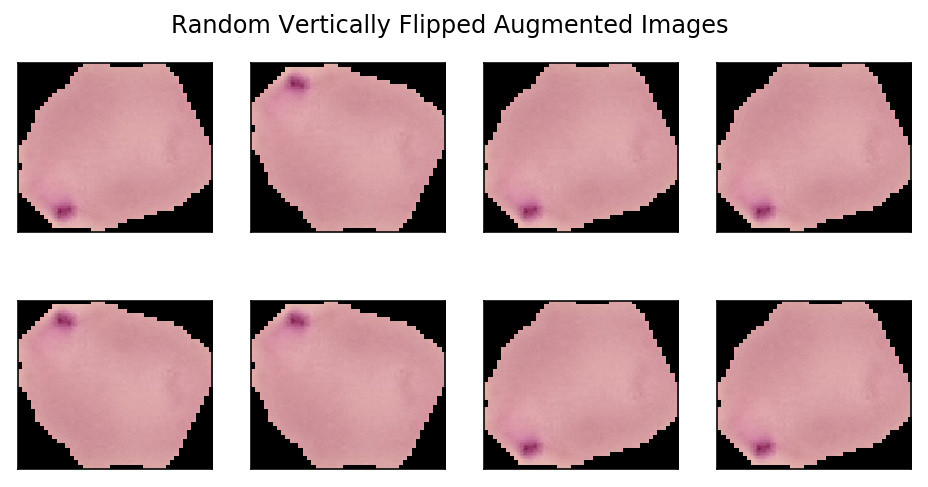

In [15]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.VERTICAL_FLIP.value)

<a name='6.2.7.2'></a>
#### 2.7.2  Horizontal and Vertical Shift Augmentation

**HORIZONTAL SHIFT**

<br>

***Original vs. Augmented Images...***

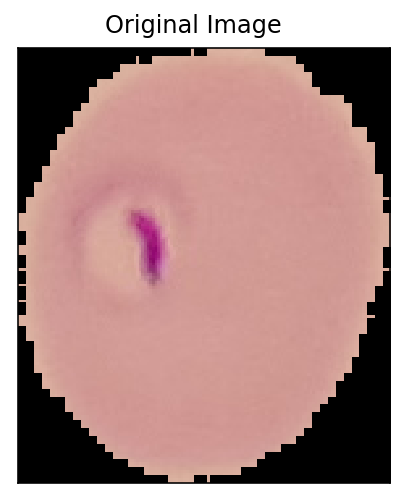

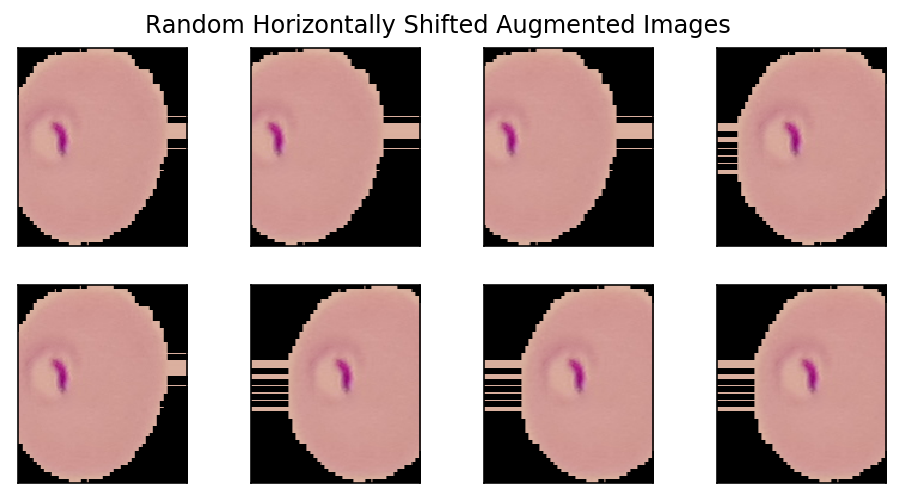

In [16]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.HORIZONTAL_SHIFT.value)

 **VERTICAL SHIFT**

<br>

***Original vs. Augmented Images...***

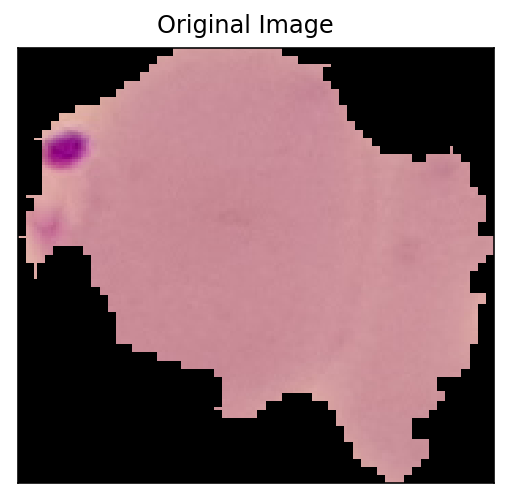

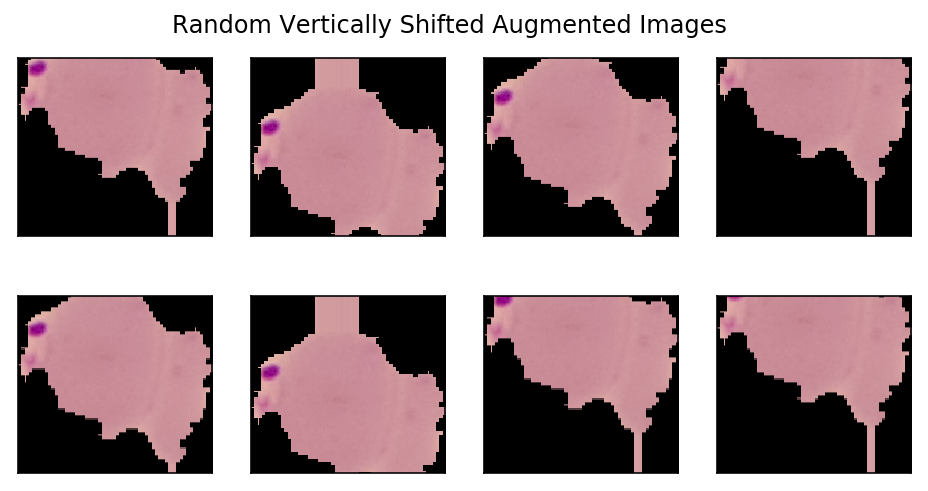

In [17]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.VERTICAL_SHIFT.value)

<a name='6.2.7.3'></a>
#### 2.7.3 Random Rotation Augmentation

<br>

***Original vs. Augmented Images...***

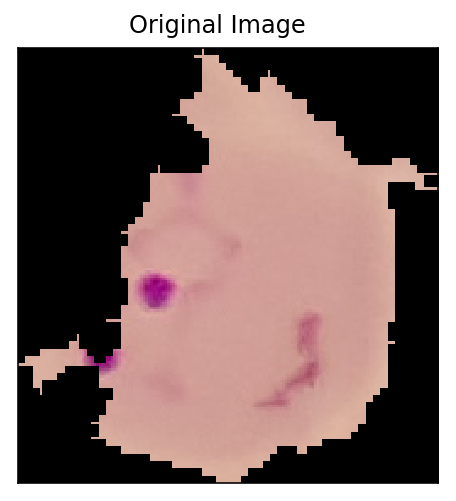

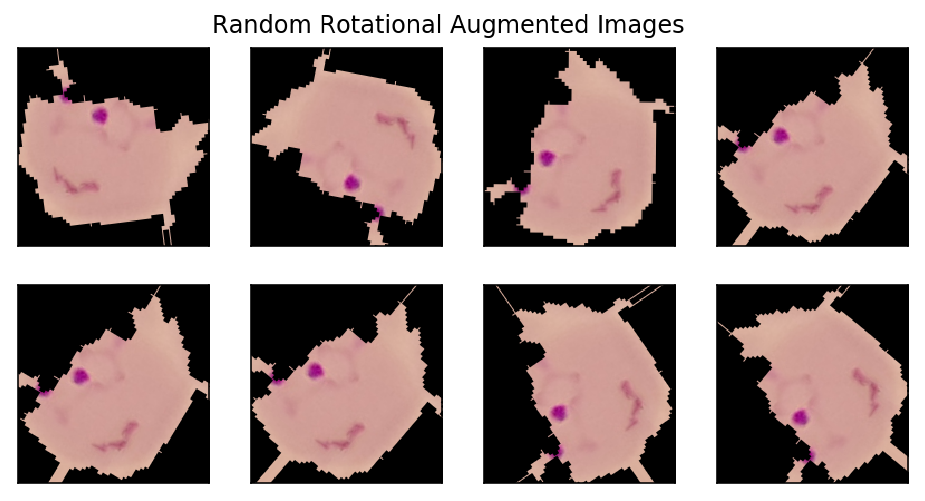

In [18]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_ROTATION.value)

<a name='6.2.7.4'></a>
#### 2.7.4 Random Brightness Augmentation

<br>

***Original vs. Augmented Images...***

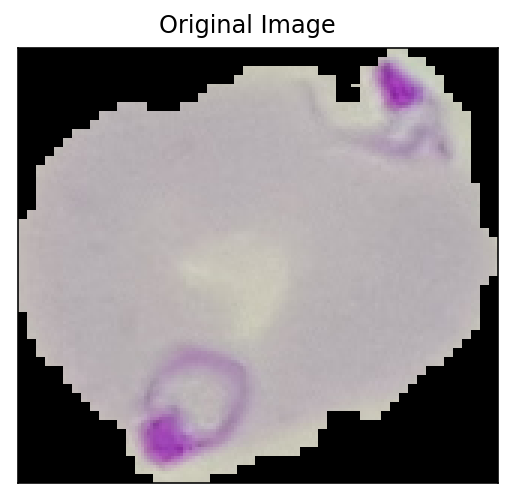

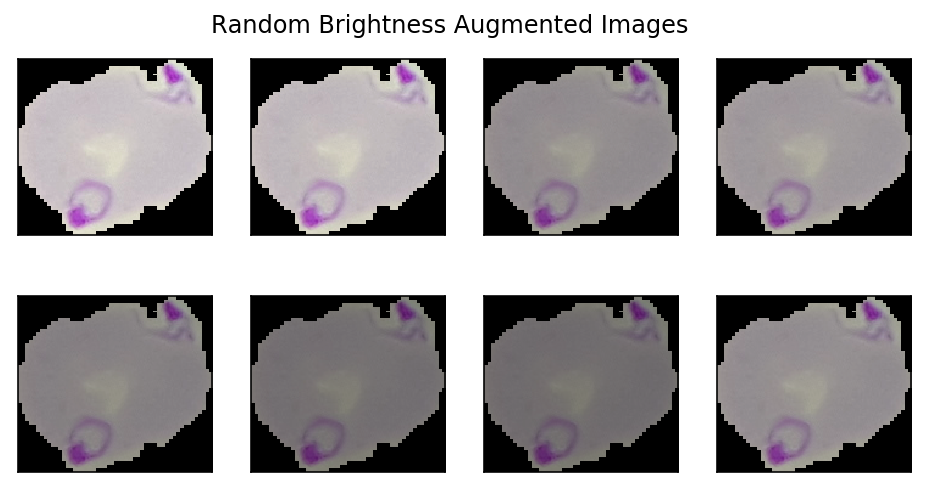

In [19]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_BRIGHTNESS.value)

<a name='6.2.7.5'></a>
#### 2.7.5 Random Zoom Augmentation

<br>

***Original vs. Augmented Images...***

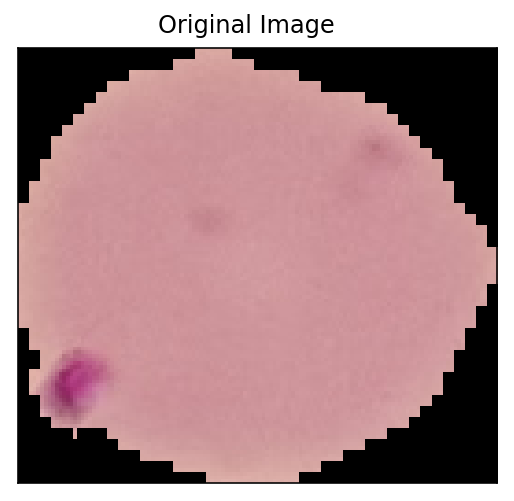

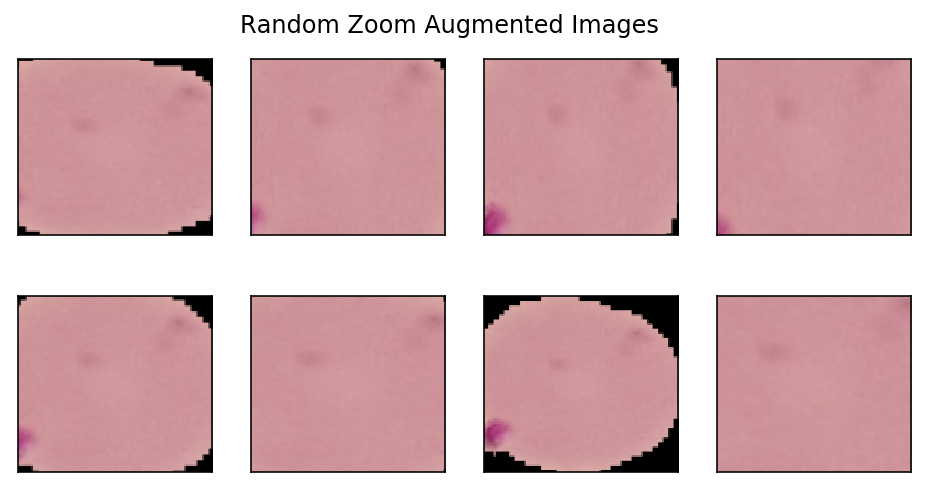

In [20]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_ZOOM.value)

<a name='6.2.7.6'></a>
#### 2.7.6 Random Shear Augmentation

<br>

***Original vs. Augmented Images...***

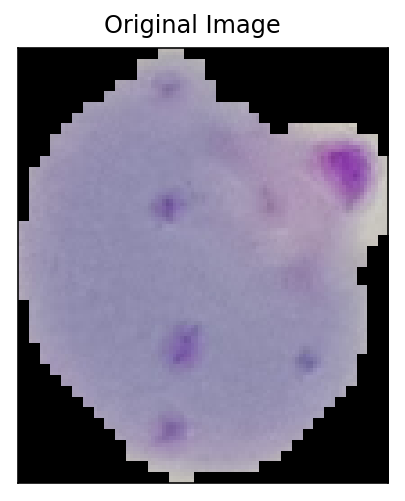

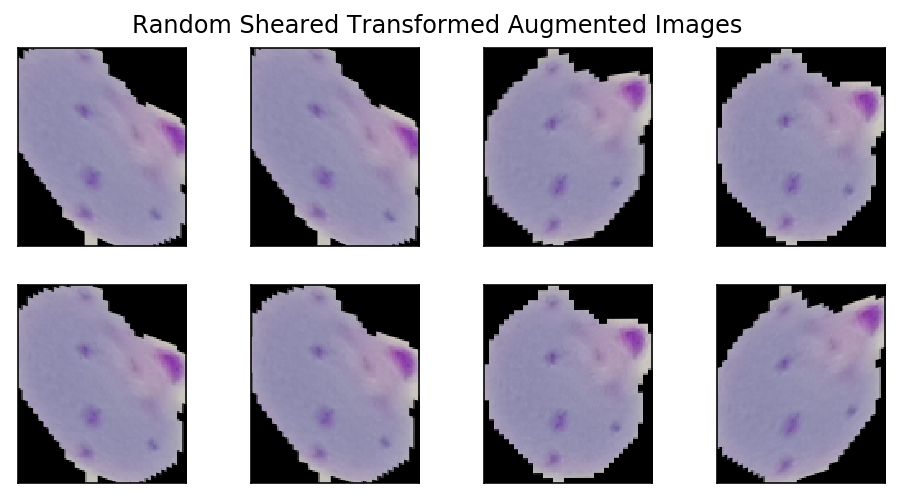

In [21]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.RANDOM_SHEAR.value)

<a name='6.2.7.7'></a>
#### 2.7.7 Random Channel Shift Augmentation

<br>

***Original vs. Augmented Images...***

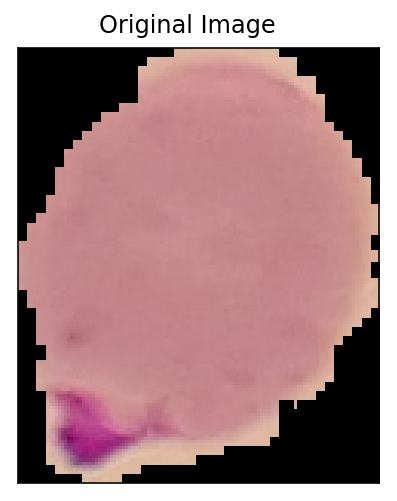

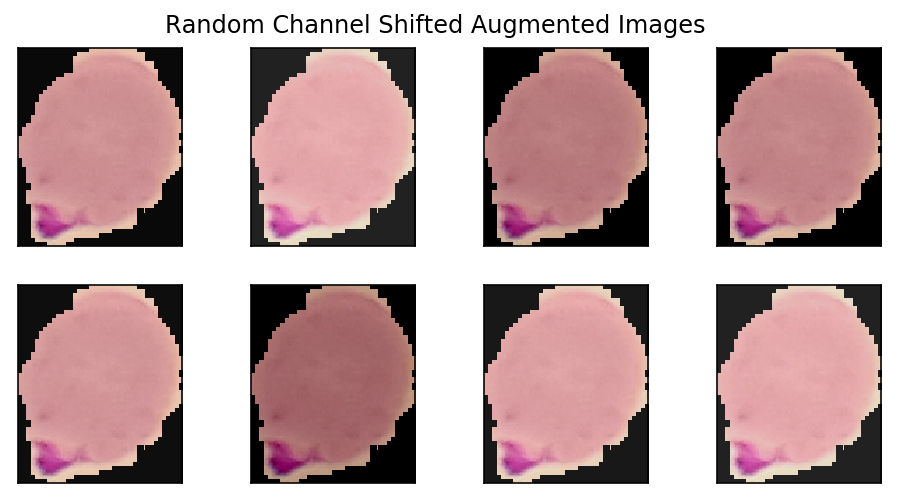

In [22]:
dUtils.PrintMarkdownText('***Original vs. Augmented Images...***')
dUtils.AugmentAndPlotData(RBC_CELL_TYPE.PARASITIZED.value, IMAGE_AUGMENTATION_TYPE.CHANNEL_SHIFT.value)

<a name='6.2.8'></a>
### 2.8 Exploratory Image Analysis - Summary

**With the above exploratory image level analysis, we saw some pre-processing techniques on images that will be the 
pre-requisites for any deep learning system based on images. A summary of the exploratory analysis done so far is 
mentioned below -**

1. **Labelling of Images:** Deep learning systems require annotated data for training. The complete set of images were labelled and divided into 2 classes - **`Parasitized (1)`** & **`Non-parasitized (0)`**.


2. **Image Dimension:** For any algorithm to run and train smoothly the inputs should all be of equal dimensions. Based on the statistical numbers, the size distribution was found to be around the 130 mark for both the parasitized and non-parasitized categories. Thus, **`(135, 135, 3)`** is choosen as the common dimension to resize the images.


3. **Histogram & Color Intensity:** Histograms and RGB color intensity were calculated and plotted on sample images from bith the classes. As seen for both the parasitized and the non-parasitized cell types, the RGB values are almost on the same intensity levels. Also, the values are around the (140 - 220) range for both the categories.


4. **Filtering & Noise Removal:** Median, gaussian and bi-lateral filtering techniques were appplied on sample images. From the corresponding filtered images it can be seen that Bilateral filter works well and it preserves the edges too. However, literature survey reveals that the median filtering is the most widely applied technique. So, it remains to be seen which technique will be the better approach for this study.


5. **Data Augmentation:** Deep learning systems require huge amount of annotated data to be available for training which enables the algorithms learn all the details and variations in the images. Due to a limited dataset available to us, some of the augmentation techniques such as flipping, shifting, rotation, zoom, shear transformation, channel shift, brightness were explored to generate more similar images. The labels of the augmentaed images will be the same as that of the original image.


In adddition to the above pre-processing techniques, all the images will undergo **Normalization** to brings the pixel intensity values to the range of 0-1 and **Standardization** such that the data points such that they follow a ***gaussian distribution*** with mean of zero and standard deviation of one.

<a name='6.3'></a>
# 3 Model Dataset Creation & Train Test Validation Split 

Any Machine Learning/Deep Learning model once trained, needs to be tested on unseen data to check the performance. 

- The data on which the **`model trains`** on is known as the **`Train Dataset`**. 


- The **`unseen data`** on which the trained model is put to **`test for performance`** and get an **`unbiased evaluation`** of the final model is known as the **`Test Dataset`**. 


- There is also an additional dataset created known as the **`Validation Dataset`** which validates the **`performance of the model fit`** during the **`tuning phase of the model hyper-parameters`**.



The percentage of data we would use to split the respective sets would be **`75:15:10`**. As deep learning systems need huge amount of training data, a major chunk - 75% is allocated to the training set. The validation set gets 10% share of the data and while the test set get 15% share.

The full malaria data set (**malaria_df**) is defined in [6.2.2 Data Labelling](#6.2.2) section. We will use the same dataset to construct our train, test and validation subsets of the data.

In [4]:
# train - test split
train_files, test_files, train_labels, test_labels = train_test_split(malaria_df['filename'].values,
                                                                      malaria_df['label'].values, 
                                                                      test_size=0.15, random_state=42)

# train - validation split
train_files, validation_files, train_labels, validation_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.10, random_state=42)

In [5]:
dUtils.PrintMarkdownText('***Length of the generated datasets...***')

print(" -- Train Set Length: " + str(len(train_files)) + ' samples'
      "\n -- Validation Set Length: "  + str(len(validation_files)) + ' samples'
      "\n -- Test Set Length: " + str(len(test_files)) + ' samples')

<br>

***Length of the generated datasets...***

 -- Train Set Length: 21081 samples
 -- Validation Set Length: 2343 samples
 -- Test Set Length: 4134 samples


In [25]:
# Get the Tally of occurrences of the 2 labels in the generated datasets...

dUtils.PrintMarkdownText('***Tally of occurrences of the 2 labels in the generated datasets...***')

print('Training Data:', Counter(train_labels), 
      '\n\nValidation Data:', Counter(validation_labels), 
      '\n\nTest Data:', Counter(test_labels))

<br>

***Tally of occurrences of the 2 labels in the generated datasets...***

Training Data: Counter({'NonParasitized': 10548, 'Parasitized': 10533}) 

Validation Data: Counter({'Parasitized': 1173, 'NonParasitized': 1170}) 

Test Data: Counter({'Parasitized': 2073, 'NonParasitized': 2061})


<a name='6.3.1'></a>
### 3.1 Image Rezise - Train Test Validation ImageSets

As discussed in [Section 6.2.3](#6.2.3) for Image Dimensions, statistical summary, the images will be resized to 
**`(135, 135)`**. However, for certain pre-trained models for transfer learning the images will be re-sized to the preffered size depending on the models.

In [5]:
IMG_RESIZE_DIMENSIONS = (135, 135)

In [6]:
train_data = dUtils.ResizeAllImages(train_files, IMG_RESIZE_DIMENSIONS)
validation_data = dUtils.ResizeAllImages(validation_files, IMG_RESIZE_DIMENSIONS)
test_data = dUtils.ResizeAllImages(test_files, IMG_RESIZE_DIMENSIONS)

In [7]:
dUtils.PrintMarkdownText('***Train, Test & Validation Image Dimensional Summary...***')
print('Training Data:', train_data.shape, 
      '\n\nValidation Data:', validation_data.shape, 
      '\n\nTest Data:',test_data.shape)

<br>

***Train, Test & Validation Image Dimensional Summary...***

Training Data: (21081, 100, 100, 3) 

Validation Data: (2343, 100, 100, 3) 

Test Data: (4134, 100, 100, 3)


<a name='6.3.2'></a>
### 3.2 Label Encoding

Encode categorical values **(`'Parasitized' & 'NonParasitized'`)** to convert to the machine readable and interpretable values which would be 0 and 1.

In [7]:
lbl_encoder = LabelEncoder()
lbl_encoder.fit(train_labels)

y_train = lbl_encoder.transform(train_labels)
y_validation = lbl_encoder.transform(validation_labels)
y_test = lbl_encoder.transform(test_labels)

dUtils.PrintMarkdownText('***Categorical & Encoded Training Labels...***')
print("Categorical Train Labels:", list(train_labels[:5]), 
      "\n\nEncoded Train Labels:    ", y_train[:5])

<br>

***Categorical & Encoded Training Labels...***

Categorical Train Labels: ['Parasitized', 'NonParasitized', 'Parasitized', 'Parasitized', 'NonParasitized'] 

Encoded Train Labels:     [1 0 1 1 0]


*From the above result -*
__________________________

- 1 denotes **`'Parasitized'`** 
- 0 corresponds to **`'NonParasitized'`**

In [8]:
# X_train = train_data / 255.
# X_val = validation_data / 255.
X_test = test_data / 255.

<a name='6.4'></a>
## 4 Model Training & Validation

In [9]:
BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 50
INPUT_SHAPE = (135, 135, 3)

<a name='6.4.6'></a>
## 4.1 Ensemble Learning - SnapShot Ensembling

<a name='4.1.1'></a>
## 4.1.1 Custom Model Snapshots

In [10]:
x_in = Input(shape=INPUT_SHAPE)
snapshot_test_model = SnapshotEnsemble.Custom_Model_With_Avg_Pooling(x_in)

snapshot_test_model.compile(optimizer='adam', #SGD(lr=0.01, momentum=0.9, nesterov=True),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

In [11]:
snap_dir = snapshot_test_model.name + "_Model_Snapshots"
snaps_cb = SnapshotEnsemble(snap_dir, n_epochs=EPOCHS, verbose=1, n_cycles=5)
CallBackList = [snaps_cb]

In [12]:
# train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

# Get the training and validation samples
train_samples = MalNetImageGenerator.Build_Image_Samples(train_files, train_labels)
validation_samples = MalNetImageGenerator.Build_Image_Samples(validation_files, validation_labels)

# Get the training and validation data generators
train_data_generator = MalNetImageGenerator.CustomImageDataGenerator(train_samples)
validation_data_generator = MalNetImageGenerator.CustomImageDataGenerator(validation_samples)

In [13]:
# snapshot_test_model_Train_History = MalNetTrainer.fit_generator(snapshot_test_model,
#                                                                           train_gen, 
#                                                                           EPOCHS, 
#                                                                           val_gen, 
#                                                                           CallBackList)

snapshot_test_model_Train_History = MalNetTrainer.fit_generator(snapshot_test_model,
                                                                train_data_generator, 
                                                                EPOCHS, 
                                                                validation_data_generator, 
                                                                CallBackList,
                                                                total_train_samples = len(train_samples), 
                                                                total_validation_samples = len(validation_samples))

<br>

***Model Training Started...***

Inside Set Model
self.base_lr 0.0010000000474974513
Epoch 1/50
329/329 [==============================] - 402s 1s/step - loss: 0.5174 - accuracy: 0.7549 - val_loss: 0.4592 - val_accuracy: 0.7704

Epoch 2: Cosine Annealing updating learning rate to 0.0009755283044826828.
Epoch 2/50
329/329 [==============================] - 25s 77ms/step - loss: 0.2305 - accuracy: 0.9252 - val_loss: 1.1733 - val_accuracy: 0.5174

Epoch 3: Cosine Annealing updating learning rate to 0.000904508540149322.
Epoch 3/50
329/329 [==============================] - 25s 76ms/step - loss: 0.1881 - accuracy: 0.9393 - val_loss: 0.3556 - val_accuracy: 0.8459

Epoch 4: Cosine Annealing updating learning rate to 0.0007938926638541129.
Epoch 4/50
329/329 [==============================] - 25s 75ms/step - loss: 0.1669 - accuracy: 0.9456 - val_loss: 0.2749 - val_accuracy: 0.9214

Epoch 5: Cosine Annealing updating learning rate to 0.0006545085282749592.
Epoch 5/50
329/329 [==============================] - 24s 73ms/step - 

329/329 [==============================] - 23s 69ms/step - loss: 0.0695 - accuracy: 0.9754 - val_loss: 0.1324 - val_accuracy: 0.9575

Epoch 36: Cosine Annealing updating learning rate to 0.0005000000237487257.
Epoch 36/50
329/329 [==============================] - 24s 72ms/step - loss: 0.0614 - accuracy: 0.9792 - val_loss: 0.1642 - val_accuracy: 0.9557

Epoch 37: Cosine Annealing updating learning rate to 0.00034549151922249217.
Epoch 37/50
329/329 [==============================] - 23s 69ms/step - loss: 0.0551 - accuracy: 0.9799 - val_loss: 0.1498 - val_accuracy: 0.9579

Epoch 38: Cosine Annealing updating learning rate to 0.00020610738364333845.
Epoch 38/50
329/329 [==============================] - 23s 69ms/step - loss: 0.0520 - accuracy: 0.9808 - val_loss: 0.1632 - val_accuracy: 0.9553

Epoch 39: Cosine Annealing updating learning rate to 9.549150734812934e-05.
Epoch 39/50
329/329 [==============================] - 23s 70ms/step - loss: 0.0490 - accuracy: 0.9830 - val_loss: 0.1455 

In [22]:
test_score = snapshot_test_model.evaluate(X_test, y_test)

print("\nEvaluation Results on Test Data...\n")
print("Loss:", test_score[0])
print("Accuracy:", test_score[1])

130/130 [==============================] - 1s 9ms/step - loss: 0.1611 - accuracy: 0.9654

Evaluation Results on Test Data...
Loss: 0.16106554865837097
Accuracy: 0.9654088020324707


<a name='4.1.1.1'></a>
## 4.1.1.1 Custom Ensemble Creation

In [25]:
ensembled_model = SnapshotEnsemble.Load_Ensembled_Model(snap_dir)

print("Evaluating Ensembled Model...")
ensemble_eval_score = ensembled_model.evaluate(X_test, y_test)

print("\nEvaluation Results on Test Data...\n")
print("Loss:", ensemble_eval_score[0])
print("Accuracy:", ensemble_eval_score[1])

percent_inc_in_acc = ((ensemble_eval_score[1] - test_score[1])/test_score[1]) * 100
percent_dec_in_acc = ((test_score[0] - ensemble_eval_score[0])/test_score[0]) * 100

print("%-age increase in Accuracy:", percent_inc_in_acc)
print("%-age decrease in Loss:", percent_dec_in_acc)



Ensembling Snapshot Models

Loading Snapshots...
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots/model_snapshot_4.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots/model_snapshot_2.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots/model_snapshot_1.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots/model_snapshot_5.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots/model_snapshot_3.h5


Evaluating Ensembled Model...
130/130 [==============================] - 3s 23ms/step - loss: 0.0971 - accuracy: 0.9688

Evaluation Results on Test Data...

Loss: 0.0971374660730362
Accuracy: 0.9687953591346741
%-age increase in Accuracy: 0.35078995499871823
%-age decrease in Loss: 39.690724129298324


In [51]:
snap_dir = 'Custom_Model_With_Avg_Pooling_Model_Snapshots'
Custom_Model_Snap = SnapshotEnsemble.Load_Ensembled_Model(snap_dir)

print("Evaluating Ensembled Model...")
Custom_Model_Snap_Score = Custom_Model_Snap.evaluate(X_test, y_test)


Ensembling Snapshot Models

Loading Snapshots...
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots\model_snapshot_1.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots\model_snapshot_2.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots\model_snapshot_3.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots\model_snapshot_4.h5
>>> Loaded --  Custom_Model_With_Avg_Pooling_Model_Snapshots\model_snapshot_5.h5


Evaluating Ensembled Model...
130/130 [==============================] - 22s 165ms/step - loss: 0.0660 - accuracy: 0.9777


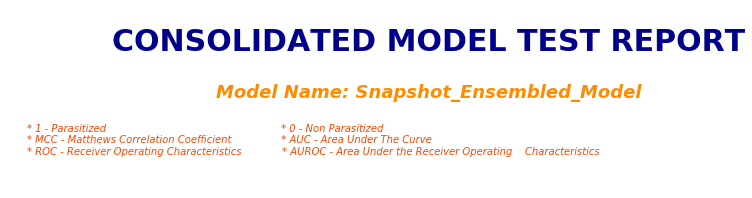

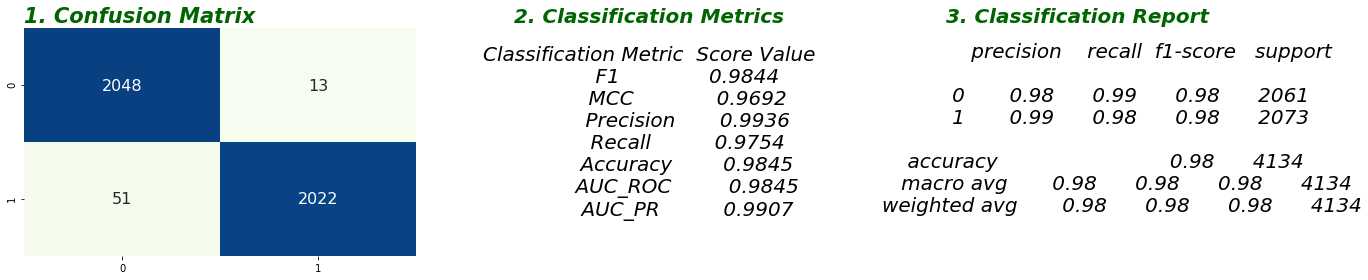

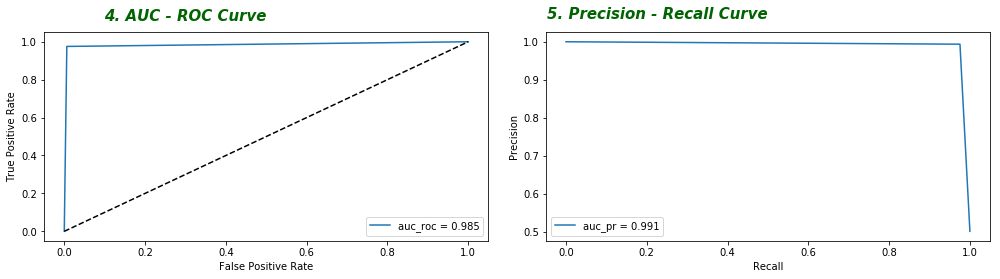

In [50]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(Custom_Model_Snap, X_test)

MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "Snapshot_Ensembled_Model")

<a name='4.1.1.2'></a>
### 4.1.1.2 Custom Snapshots -  Test Metrics

In [11]:
metrics=['F1 - Score', 'Accuracy', 'Precision', 'Recall', 'MCC']

snap1 = [0.9624, 0.9630, 0.9814, 0.9440, 0.9267]
snap2 = [0.9682, 0.9686, 0.9817, 0.9551, 0.9375]
snap3 = [0.9743, 0.9746, 0.9881, 0.9609, 0.9496]
snap4 = [0.9807, 0.9809, 0.9936, 0.9682, 0.9621]
snap5 = [0.9852, 0.9852, 0.9936, 0.9768, 0.9706]

fig = go.Figure(data=[
    go.Bar(name='Snapshot - 1', x=metrics, y=snap1, text=snap1, textposition='auto'),
    go.Bar(name='Snapshot - 2', x=metrics, y=snap2, text=snap2, textposition='auto'),
    go.Bar(name='Snapshot - 3', x=metrics, y=snap3, text=snap3, textposition='auto'),
    go.Bar(name='Snapshot - 4', x=metrics, y=snap4, text=snap4, textposition='auto'),
    go.Bar(name='Snapshot - 5', x=metrics, y=snap5, text=snap5, textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='group')
fig['layout']['yaxis'].update(title='Metric Values', range=[0.94, 1], dtick=0.07, autorange=False)
fig['layout']['xaxis'].update(title='Classification Metrics')
fig.update_layout(title="Model Snapshots vs. Classification Metrics...")
fig.show()

# TEST ERROR RATE
metrics=['Error Rate']
snap1_err = [0.1145]
snap2_err = [0.0899]
snap3_err = [0.0719]
snap4_err = [0.0606]
snap5_err = [0.0598]

fig = go.Figure(data=[
    go.Bar(name='Snapshot - 1', x=metrics, y=snap1_err, text=snap1_err, textposition='auto'),
    go.Bar(name='Snapshot - 2', x=metrics, y=snap2_err, text=snap2_err, textposition='auto'),
    go.Bar(name='Snapshot - 3', x=metrics, y=snap3_err, text=snap3_err, textposition='auto'),
    go.Bar(name='Snapshot - 4', x=metrics, y=snap4_err, text=snap4_err, textposition='auto'),
    go.Bar(name='Snapshot - 5', x=metrics, y=snap5_err, text=snap5_err, textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='group')
fig['layout']['yaxis'].update(title='Error Value', range=[0, 0.12], dtick=0.03, autorange=False)
fig['layout']['xaxis'].update(title='Classification Metrics')
fig.update_layout(title="Test Time Error in Model Snapshots...")
fig.show()

<a name='4.1.2'></a>
## 4.1.2 EfficientNet-B0 Model Snapshots

In [10]:
x_in = Input(shape=INPUT_SHAPE)
TL_EfficientNet_B0 = SnapshotEnsemble.GetEfficientNetB0Model(x_in, bTrainConvolutionBase=True)

TL_EfficientNet_B0.compile(optimizer='adam',
                           loss='binary_crossentropy',
                           metrics=['accuracy'])

In [11]:
snap_dir = TL_EfficientNet_B0.name + "_Model_Snapshots"
snaps_cb = SnapshotEnsemble(snap_dir, n_epochs=EPOCHS, verbose=1, n_cycles=5)
CallBackList = [snaps_cb]

In [12]:
train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [13]:
TL_EfficientNet_B0_Train_History = MalNetTrainer.fit_generator(TL_EfficientNet_B0,
                                                               train_gen, 
                                                               EPOCHS, 
                                                               val_gen, 
                                                               CallBackList)

<br>

***Model Training Started...***

Inside Set Model
self.base_lr 0.0010000000474974513
Epoch 1/50
329/329 [==============================] - 145s 440ms/step - loss: 0.1338 - accuracy: 0.9535 - val_loss: 0.1534 - val_accuracy: 0.9609

Epoch 2: Cosine Annealing updating learning rate to 0.0009755283044826828.
Epoch 2/50
329/329 [==============================] - 143s 434ms/step - loss: 0.1019 - accuracy: 0.9638 - val_loss: 0.1128 - val_accuracy: 0.9609

Epoch 3: Cosine Annealing updating learning rate to 0.000904508540149322.
Epoch 3/50
329/329 [==============================] - 143s 433ms/step - loss: 0.0891 - accuracy: 0.9697 - val_loss: 0.1171 - val_accuracy: 0.9596

Epoch 4: Cosine Annealing updating learning rate to 0.0007938926638541129.
Epoch 4/50
329/329 [==============================] - 142s 433ms/step - loss: 0.0821 - accuracy: 0.9695 - val_loss: 0.1006 - val_accuracy: 0.9627

Epoch 5: Cosine Annealing updating learning rate to 0.0006545085282749592.
Epoch 5/50
329/329 [==============================] - 142s 43

329/329 [==============================] - 144s 436ms/step - loss: 0.0314 - accuracy: 0.9891 - val_loss: 0.1017 - val_accuracy: 0.9683

Epoch 36: Cosine Annealing updating learning rate to 0.0005000000237487257.
Epoch 36/50
329/329 [==============================] - 143s 435ms/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.1089 - val_accuracy: 0.9727

Epoch 37: Cosine Annealing updating learning rate to 0.00034549151922249217.
Epoch 37/50
329/329 [==============================] - 143s 436ms/step - loss: 0.0218 - accuracy: 0.9915 - val_loss: 0.1129 - val_accuracy: 0.9718

Epoch 38: Cosine Annealing updating learning rate to 0.00020610738364333845.
Epoch 38/50
329/329 [==============================] - 143s 436ms/step - loss: 0.0167 - accuracy: 0.9938 - val_loss: 0.1112 - val_accuracy: 0.9744

Epoch 39: Cosine Annealing updating learning rate to 9.549150734812934e-05.
Epoch 39/50
329/329 [==============================] - 143s 435ms/step - loss: 0.0142 - accuracy: 0.9952 - val_los

In [14]:
TL_EfficientNet_B0_Score = TL_EfficientNet_B0.evaluate(X_test, y_test)

print("\nParent Model Evaluation Results on Test Data...\n")
print("Loss:", TL_EfficientNet_B0_Score[0])
print("Accuracy:", TL_EfficientNet_B0_Score[1])

130/130 [==============================] - 7s 57ms/step - loss: 0.1059 - accuracy: 0.9773

Parent Model Evaluation Results on Test Data...

Loss: 0.10593647509813309
Accuracy: 0.9772617220878601


<a name='4.1.2.1'></a>

## 4.1.2.1 Ensemble Creation

In [25]:
Ensembled_EfficientNet_B0 = Load_Ensembled_Model(snap_dir)

print("Evaluating Ensembled Model...")
Ensembled_EfficientNet_B0_Score = Ensembled_EfficientNet_B0.evaluate(X_test, y_test)

# print("\nEnsembled Model Evaluation Results on Test Data...\n")
# print("Loss:", Ensembled_EfficientNet_B0_Score[0])
# print("Accuracy:", Ensembled_EfficientNet_B0_Score[1])

# percent_inc_in_acc = ((Ensembled_EfficientNet_B0_Score[1] - TL_EfficientNet_B0_Score[1])/TL_EfficientNet_B0_Score[1]) * 100
# percent_dec_in_acc = ((TL_EfficientNet_B0_Score[0] - Ensembled_EfficientNet_B0_Score[0])/TL_EfficientNet_B0_Score[0]) * 100

# print("%-age increase in Accuracy:", percent_inc_in_acc)
# print("%-age decrease in Loss:", percent_dec_in_acc)


Ensembling Snapshot Models

Loading Snapshots...
>>> Loaded --  TL_Ensemble_EfficientNet_B0_Model_Snapshots/model_snapshot_4.h5
>>> Loaded --  TL_Ensemble_EfficientNet_B0_Model_Snapshots/model_snapshot_2.h5
>>> Loaded --  TL_Ensemble_EfficientNet_B0_Model_Snapshots/model_snapshot_1.h5
>>> Loaded --  TL_Ensemble_EfficientNet_B0_Model_Snapshots/model_snapshot_5.h5
>>> Loaded --  TL_Ensemble_EfficientNet_B0_Model_Snapshots/model_snapshot_3.h5
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7_0_1_2_3_4 (InputLayer)  [(None, 135, 135, 3) 0                                            
__________________________________________________________________________________________________
stem_conv_0 (Conv2D)            (None, 68, 68, 32)   864         input_7_0_1_2_3_4[0][0]          
___________________________________________

block4b_project_bn_1 (BatchNorm (None, 9, 9, 80)     320         block4b_project_conv_1[0][0]     
__________________________________________________________________________________________________
block4b_project_bn_2 (BatchNorm (None, 9, 9, 80)     320         block4b_project_conv_2[0][0]     
__________________________________________________________________________________________________
block4b_project_bn_3 (BatchNorm (None, 9, 9, 80)     320         block4b_project_conv_3[0][0]     
__________________________________________________________________________________________________
block4b_project_bn_4 (BatchNorm (None, 9, 9, 80)     320         block4b_project_conv_4[0][0]     
__________________________________________________________________________________________________
block4b_drop_0 (FixedDropout)   (None, 9, 9, 80)     0           block4b_project_bn_0[0][0]       
__________________________________________________________________________________________________
block4b_dr

block6c_expand_bn_4 (BatchNorma (None, 5, 5, 1152)   4608        block6c_expand_conv_4[0][0]      
__________________________________________________________________________________________________
block6c_expand_activation_0 (Ac (None, 5, 5, 1152)   0           block6c_expand_bn_0[0][0]        
__________________________________________________________________________________________________
block6c_expand_activation_1 (Ac (None, 5, 5, 1152)   0           block6c_expand_bn_1[0][0]        
__________________________________________________________________________________________________
block6c_expand_activation_2 (Ac (None, 5, 5, 1152)   0           block6c_expand_bn_2[0][0]        
__________________________________________________________________________________________________
block6c_expand_activation_3 (Ac (None, 5, 5, 1152)   0           block6c_expand_bn_3[0][0]        
__________________________________________________________________________________________________
block6c_ex

130/130 [==============================] - 33s 253ms/step - loss: 0.0651 - accuracy: 0.9809


<a name='4.1.2.2'></a>

## 4.1.2.2 Test Metrics Comparison

In [26]:
print("\nEnsembled Model Evaluation Results on Test Data...\n")
print("Loss:", Ensembled_EfficientNet_B0_Score[0])
print("Accuracy:", Ensembled_EfficientNet_B0_Score[1])

percent_inc_in_acc = ((Ensembled_EfficientNet_B0_Score[1] - TL_EfficientNet_B0_Score[1])/TL_EfficientNet_B0_Score[1]) * 100
percent_dec_in_acc = ((TL_EfficientNet_B0_Score[0] - Ensembled_EfficientNet_B0_Score[0])/TL_EfficientNet_B0_Score[0]) * 100

print("%-age increase in Accuracy:", percent_inc_in_acc)
print("%-age decrease in Loss:", percent_dec_in_acc)


Ensembled Model Evaluation Results on Test Data...

Loss: 0.0650898665189743
Accuracy: 0.980890154838562
%-age increase in Accuracy: 0.3712856718617792
%-age decrease in Loss: 38.55764366458387


## Take 2

In [ ]:
# x_in = Input(shape=INPUT_SHAPE)
# TL_EfficientNet_B0 = SnapshotEnsemble.GetEfficientNetB0Model(x_in, bTrainConvolutionBase=True)

# TL_EfficientNet_B0.compile(optimizer='adam',
#                            loss='binary_crossentropy',
#                            metrics=['accuracy'])

In [ ]:
# EPOCHS = 30
# snap_dir = TL_EfficientNet_B0.name + "_Model_Snapshots_30Ep"
# snaps_cb = SnapshotEnsemble(snap_dir, n_epochs=EPOCHS, verbose=1, n_cycles=5)
# CallBackList = [snaps_cb]

In [ ]:
# train_gen, val_gen = MalNetTrainer.GetImageDataGenerators(train_data, y_train, validation_data, y_validation, BATCH_SIZE)

In [ ]:
# TL_EfficientNet_B0_Train_History = MalNetTrainer.fit_generator(TL_EfficientNet_B0,
#                                                                train_gen, 
#                                                                EPOCHS, 
#                                                                val_gen, 
#                                                                CallBackList)

In [ ]:
# TL_EfficientNet_B0_Score = TL_EfficientNet_B0.evaluate(X_test, y_test)

# print("\nParent Model Evaluation Results on Test Data...\n")
# print("Loss:", TL_EfficientNet_B0_Score[0])
# print("Accuracy:", TL_EfficientNet_B0_Score[1])

In [ ]:
# Ensembled_EfficientNet_B0 = SnapshotEnsemble.Load_Ensembled_Model(snap_dir)

# print("Evaluating Ensembled Model...")
# Ensembled_EfficientNet_B0_Score = Ensembled_EfficientNet_B0.evaluate(X_test, y_test)

In [ ]:
# print("\nEnsembled Model Evaluation Results on Test Data...\n")
# print("Loss:", Ensembled_EfficientNet_B0_Score[0])
# print("Accuracy:", Ensembled_EfficientNet_B0_Score[1])

# percent_inc_in_acc = ((Ensembled_EfficientNet_B0_Score[1] - TL_EfficientNet_B0_Score[1])/TL_EfficientNet_B0_Score[1]) * 100
# percent_dec_in_acc = ((TL_EfficientNet_B0_Score[0] - Ensembled_EfficientNet_B0_Score[0])/TL_EfficientNet_B0_Score[0]) * 100

# print("%-age increase in Accuracy:", percent_inc_in_acc)
# print("%-age decrease in Loss:", percent_dec_in_acc)

In [ ]:
# y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(Ensembled_EfficientNet_B0, X_test)
# MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "Snapshot_Ensembled_EfficientNet_B0")

<a name='4.1.2.3'></a>
## 4.1.2.3 EfficientNet-B0 Test Metric Chart

In [9]:
snap_dir = 'TL_Ensemble_EfficientNet_B0_Model_Snapshots'
# del Ensembled_EfficientNet_B0

Ensembled_EfficientNet_B0 = SnapshotEnsemble.Load_Ensembled_Model(snap_dir)

print("Evaluating Ensembled Model...")
Ensembled_EfficientNet_B0_Score = Ensembled_EfficientNet_B0.evaluate(X_test, y_test)


Ensembling Snapshot Models

Loading Snapshots...
>>> Loaded --  TL_Ensemble_EfficientNet_B0_Model_Snapshots\model_snapshot_4.h5
>>> Loaded --  TL_Ensemble_EfficientNet_B0_Model_Snapshots\model_snapshot_5.h5


Evaluating Ensembled Model...
130/130 [==============================] - 106s 814ms/step - loss: 0.0258 - accuracy: 0.9937


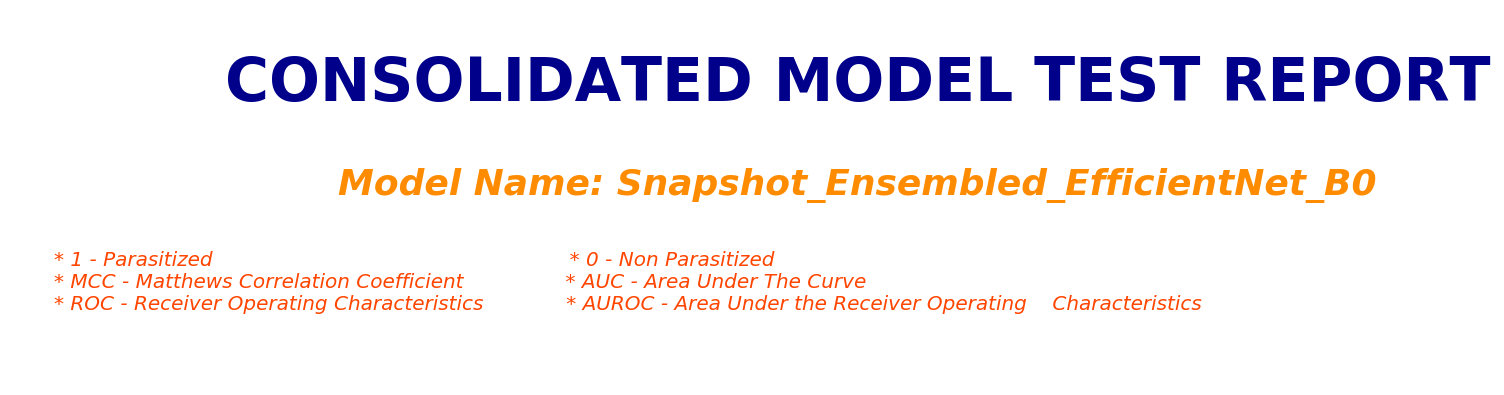

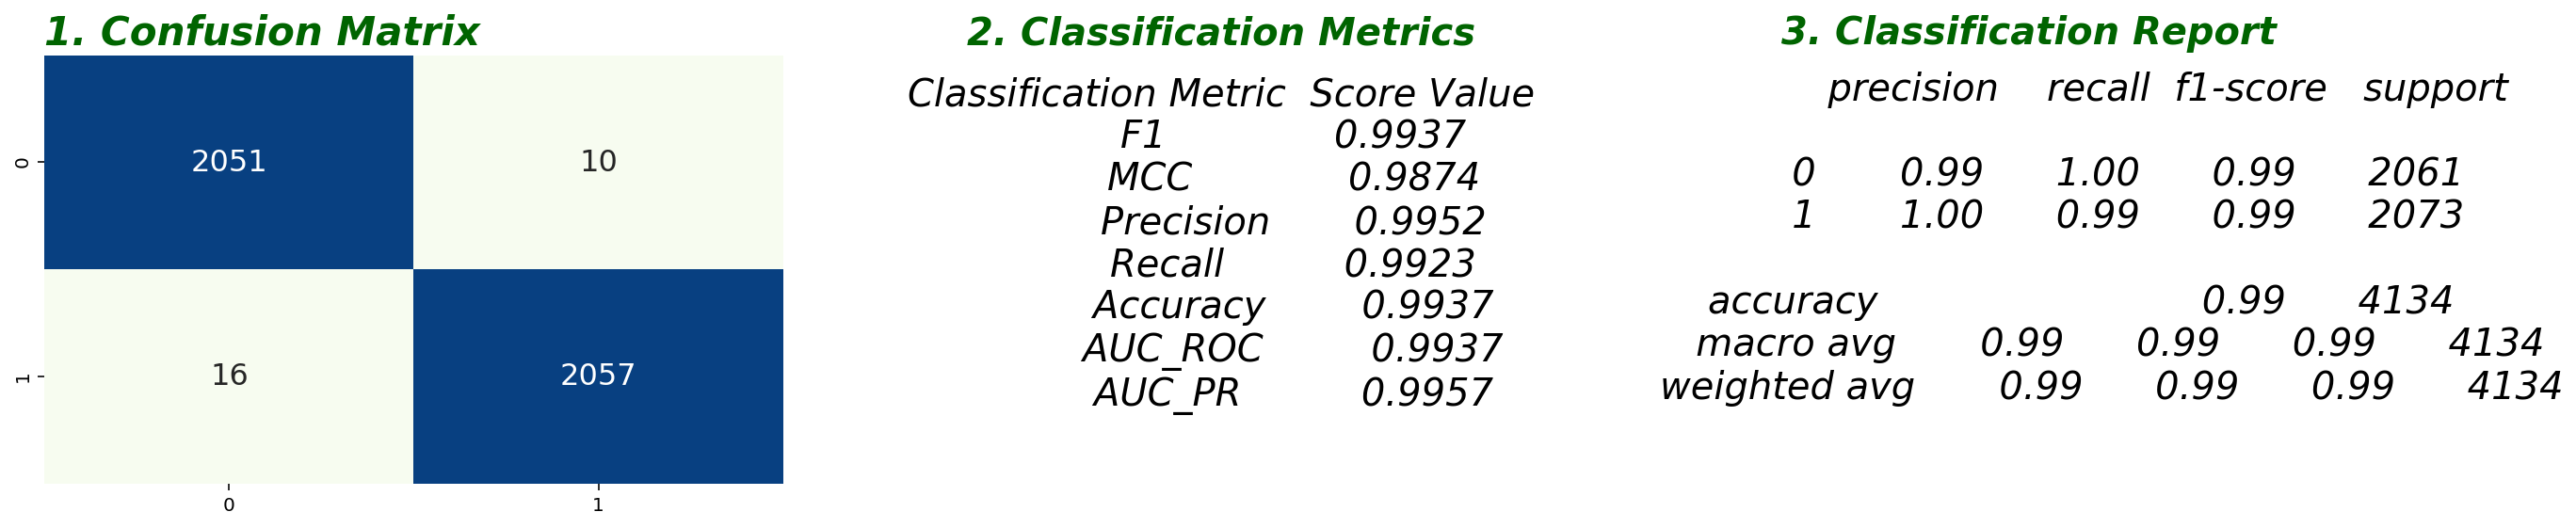

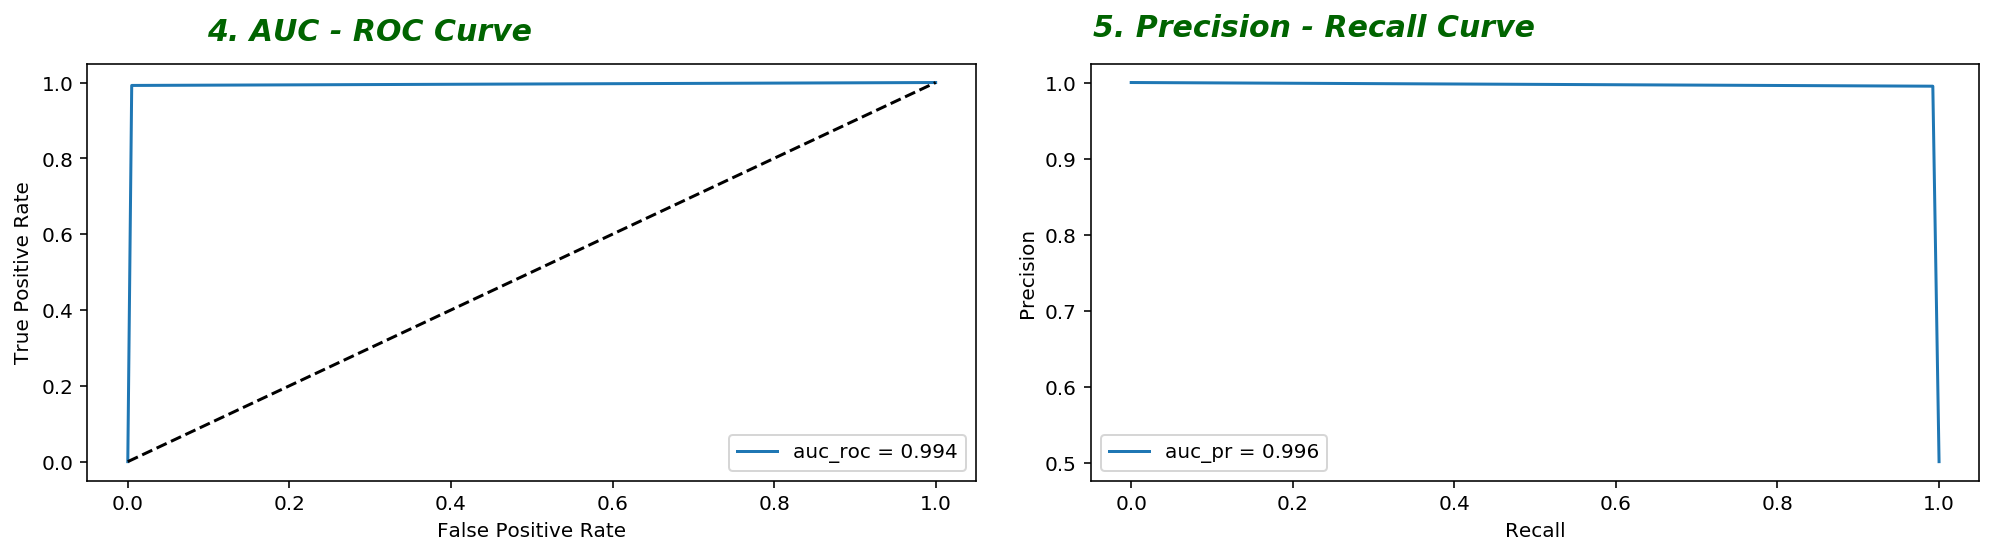

In [10]:
y_preds_probability, y_preds_binary = MalNetValidator.GetModelPredictions(Ensembled_EfficientNet_B0, X_test)
MalNetValidator.Generate_Model_Test_Classification_Report(y_test, y_preds_binary, "Snapshot_Ensembled_EfficientNet_B0")

<br>

***Model test results of 16 random test images...***

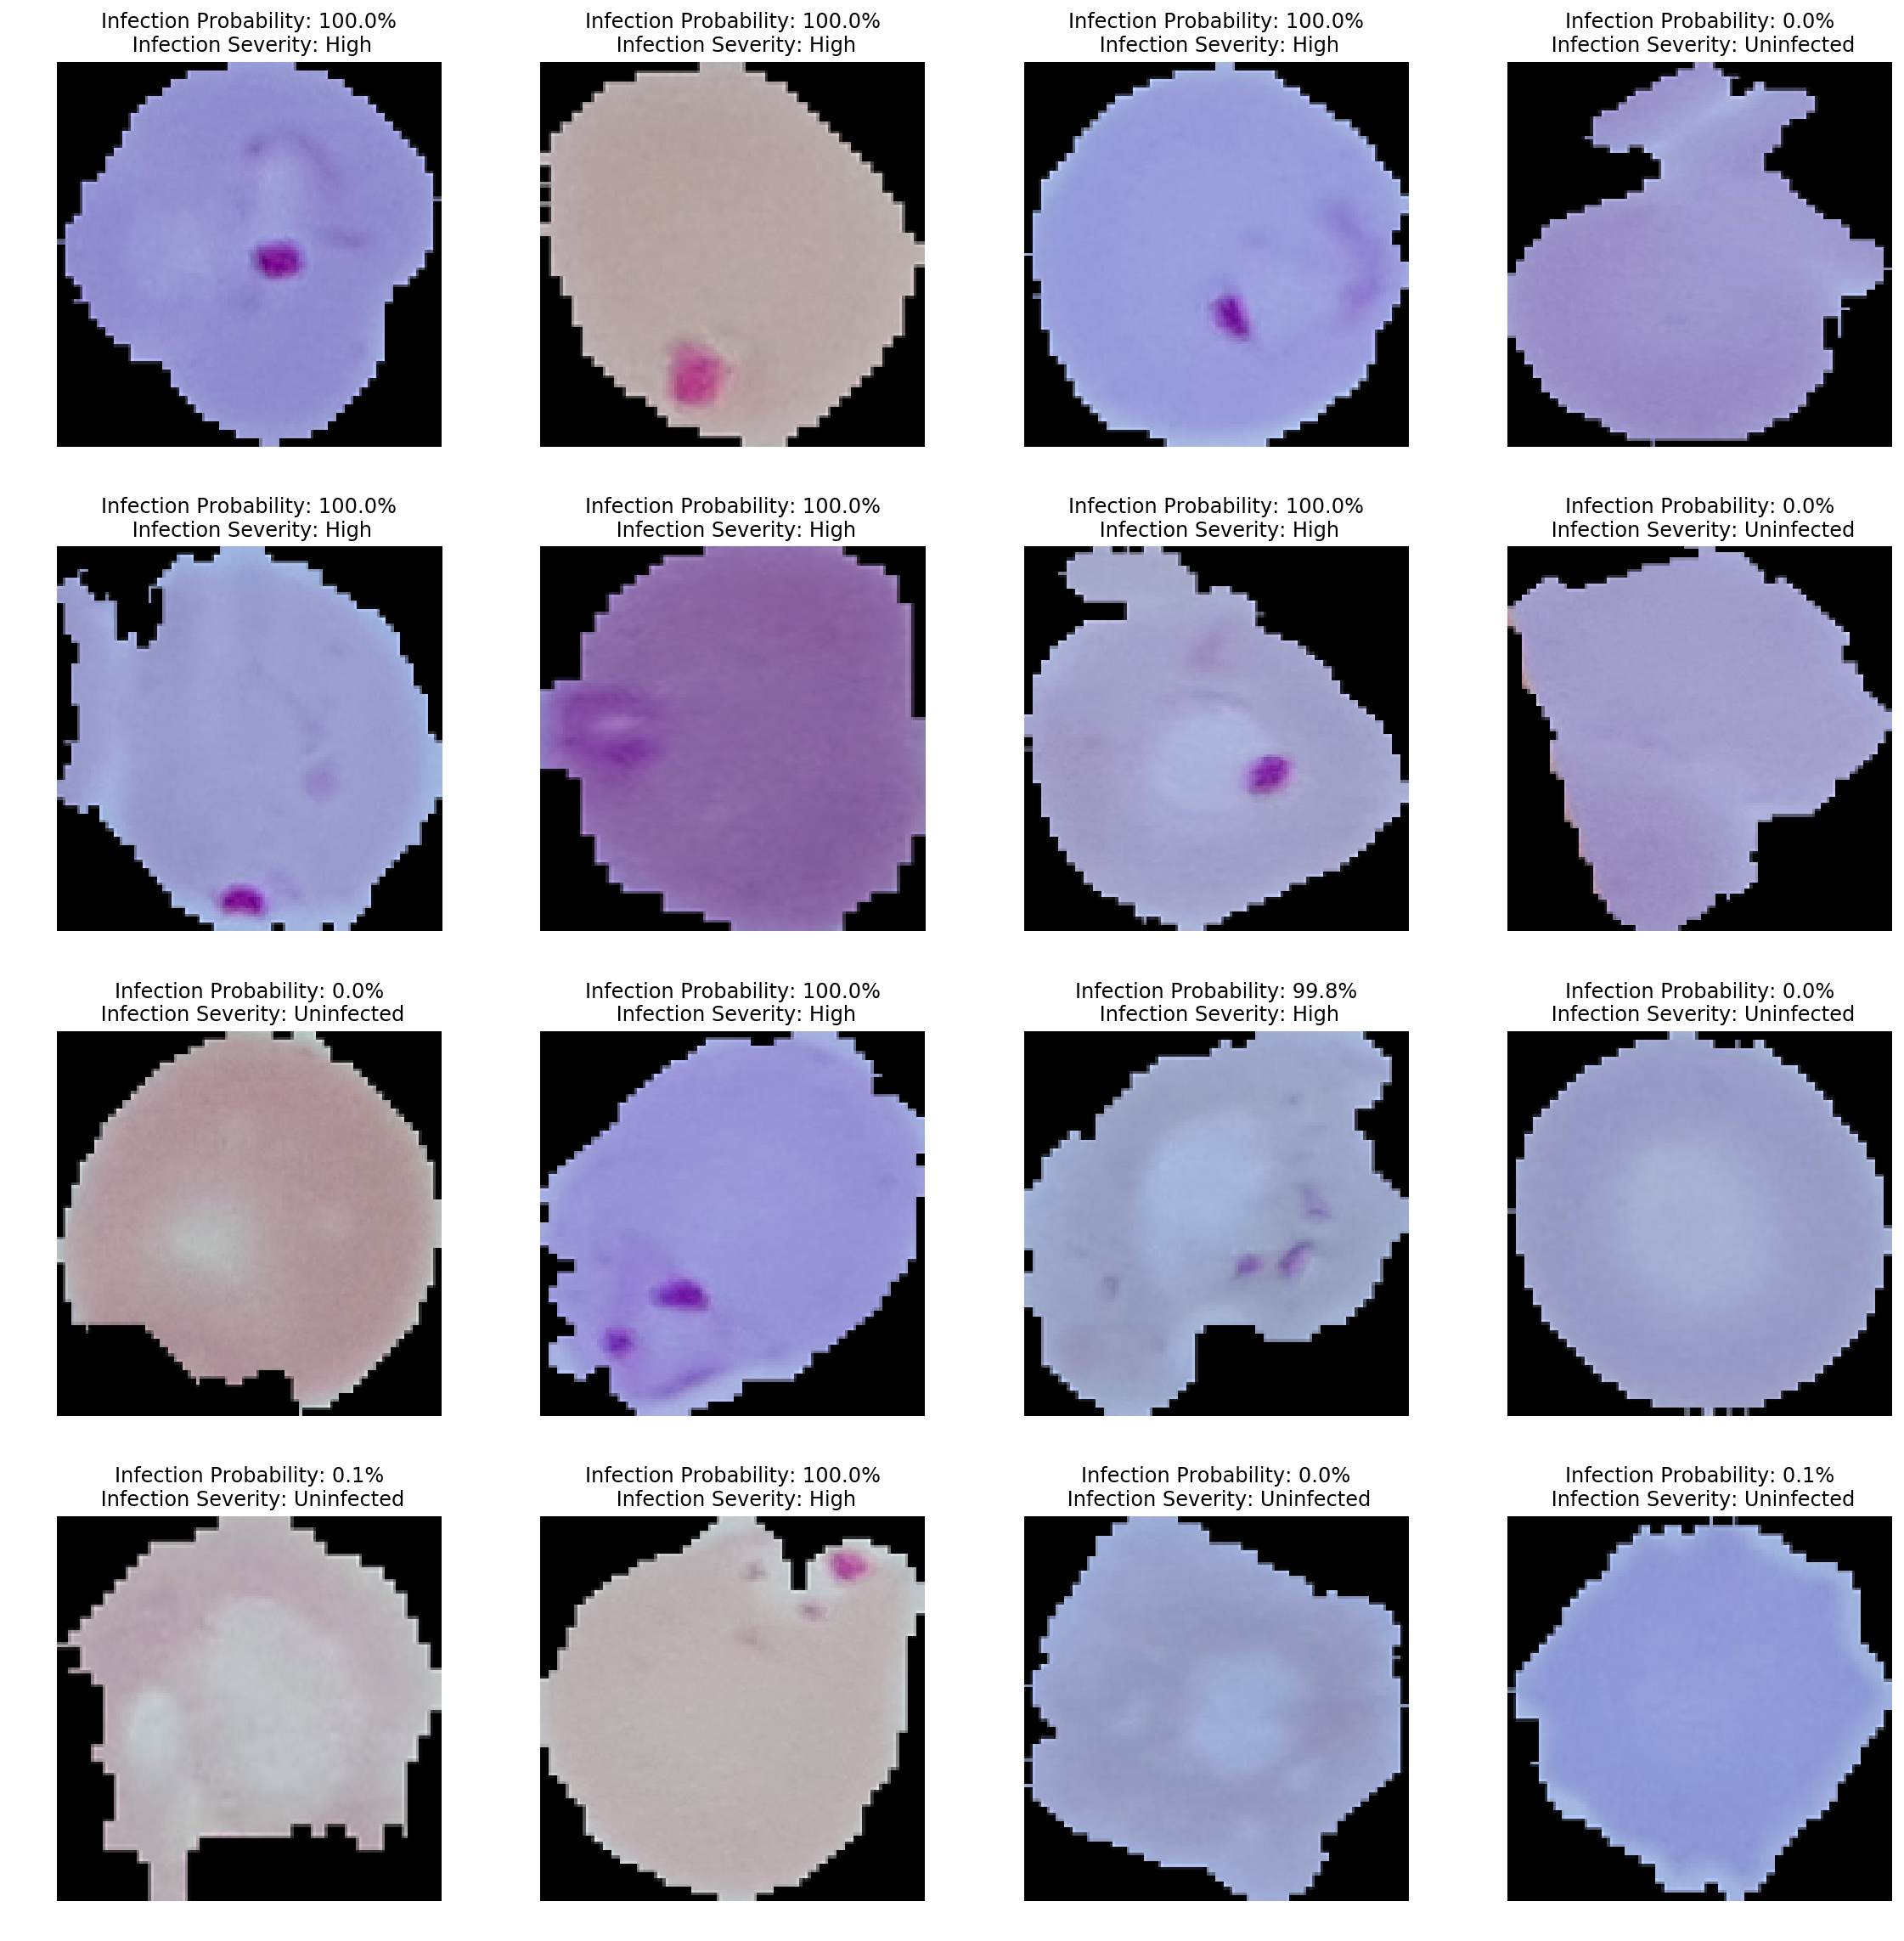

In [11]:
MalNetValidator.PlotModelPredictionsOnRandomTestImages(X_test, y_test, y_preds_probability)

<a name='4.1.2.4'></a>
### 4.1.2.4 Snapshots Test Metrics Chart 

In [11]:
metrics=['F1 - Score', 'Accuracy', 'Precision', 'Recall', 'MCC']

snap1 = [98.35, 98.36, 98.93, 97.78, 96.72]
snap2 = [98.98, 98.98, 99.32, 99.65, 97.97]
snap3 = [99.15, 99.15, 99.32, 98.99, 98.31]
snap4 = [99.28, 99.27, 99.37, 99.18, 98.55]
snap5 = [99.28, 99.27, 99.47, 99.08, 98.55]

fig = go.Figure(data=[
    go.Bar(name='EfficientNetB0 Snapshot - 1', x=metrics, y=snap1, text=snap1, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 2', x=metrics, y=snap2, text=snap2, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 3', x=metrics, y=snap3, text=snap3, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 4', x=metrics, y=snap4, text=snap4, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 5', x=metrics, y=snap5, text=snap5, textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='group')
fig['layout']['yaxis'].update(title='Metric Values', range=[95, 100], dtick=1, autorange=False)
fig['layout']['xaxis'].update(title='Classification Metrics')
fig.update_layout(title="Model Snapshots and Test Classification Metrics...")
fig.show()

# TEST ERROR RATE
metrics=['Loss Value']
snap1_err = [4.09]
snap2_err = [3.21]
snap3_err = [2.92]
snap4_err = [2.79]
snap5_err = [3.19]

fig = go.Figure(data=[
    go.Bar(name='EfficientNetB0 Snapshot - 1', x=metrics, y=snap1_err, text=snap1_err, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 2', x=metrics, y=snap2_err, text=snap2_err, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 3', x=metrics, y=snap3_err, text=snap3_err, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 4', x=metrics, y=snap4_err, text=snap4_err, textposition='auto'),
    go.Bar(name='EfficientNetB0 Snapshot - 5', x=metrics, y=snap5_err, text=snap5_err, textposition='auto')
])

# Change the bar mode
fig.update_layout(barmode='group')
fig['layout']['yaxis'].update(title='Loss Value', range=[0, 5], dtick=1, autorange=False)
fig['layout']['xaxis'].update(title='Classification Metrics')
fig.update_layout(title="Test Time Loss in Model Snapshots...")
fig.show()

<a name='4.1.2.5'></a>
### 4.1.2.5 Ensembles Test Metrics Chart

In [12]:
metrics=['F1 - Score', 'Accuracy', 'Precision', 'Recall', 'MCC']

ens12345 = [99.27, 99.27, 99.52, 99.04, 98.55]
ens2345 = [99.28, 99.27, 99.47, 99.08, 98.55]
ens234 = [99.23, 99.23, 99.47, 98.99, 98.45]
ens345 = [99.28, 99.27, 99.42, 99.13, 98.55]
ens34 = [99.32, 99.32, 99.52, 99.13, 98.65]
ens45 = [99.37, 99.37, 99.52, 99.23, 98.74]

fig = go.Figure(data=[
    go.Bar(name='Efficient Ensemble [1, 2, 3, 4, 5]', x=metrics, y=ens12345, text=ens12345, textposition='auto'),
    go.Bar(name='Efficient Ensemble [2, 3, 4, 5]', x=metrics, y=ens2345, text=ens2345, textposition='auto'),
    go.Bar(name='Efficient Ensemble [2, 3, 4]', x=metrics, y=ens234, text=ens234, textposition='auto'),
    go.Bar(name='Efficient Ensemble [3, 4, 5]', x=metrics, y=ens345, text=ens345, textposition='auto'),
    go.Bar(name='Efficient Ensemble [3, 4]', x=metrics, y=ens34, text=ens34, textposition='auto'),
    go.Bar(name='Efficient Ensemble [4, 5]', x=metrics, y=ens45, text=ens45, textposition='auto'),
])


# Change the bar mode
fig.update_layout(barmode='group')
fig['layout']['yaxis'].update(title='Metric Values', range=[98, 100], dtick=0.2, autorange=False)
fig['layout']['xaxis'].update(title='Classification Metrics')
fig.update_layout(title="Snapshot Ensembles Test Classification Metrics...")
fig.show()

# TEST ERROR RATE
metrics=['Loss Percenatge']
ens12345_err = [2.53]
ens2345_err = [2.50]
ens234_err = [2.59]

ens345_err = [2.48]
ens34_err = [2.56]
ens45_err = [2.58]

fig = go.Figure(data=[
    go.Bar(name='Efficient Ensemble [1, 2, 3, 4, 5]', x=metrics, y=ens12345_err, text=ens12345_err, textposition='auto'),
    go.Bar(name='Efficient Ensemble [2, 3, 4, 5]', x=metrics, y=ens2345_err, text=ens2345_err, textposition='auto'),
    go.Bar(name='Efficient Ensemble [2, 3, 4]', x=metrics, y=ens234_err, text=ens234_err, textposition='auto'),
    go.Bar(name='Efficient Ensemble [3, 4, 5]', x=metrics, y=ens345_err, text=ens345_err, textposition='auto'),
    go.Bar(name='Efficient Ensemble [3, 4]', x=metrics, y=ens34_err, text=ens34_err, textposition='auto'),
    go.Bar(name='Efficient Ensemble [4, 5]', x=metrics, y=ens45_err, text=ens45_err, textposition='auto'),
])

# Change the bar mode
fig.update_layout(barmode='group')
fig['layout']['yaxis'].update(title='Loss Value', range=[0, 5], dtick=1, autorange=False)
fig['layout']['xaxis'].update(title='Classification Metrics')
fig.update_layout(title="Test Time Loss in Snapshot Ensembles...")
fig.show()

<a name='5'></a>
## 5 False Case Analysis

In [44]:
# MalNetValidator.PlotModelPredictionsOnRandomTestImages(X_test, y_test, y_preds_probability)

sum(y_preds_binary != y_test)

false_preds = [index for index, elem in enumerate(y_preds_binary) if elem != y_test[index]]
print(false_preds)

[105, 123, 445, 473, 474, 717, 989, 1096, 1368, 1579, 1614, 1706, 1858, 2169, 2208, 2295, 2722, 2830, 2987, 3098, 3494, 3507, 3517, 3715, 3951, 4088]


<a name='5.1'></a>
### 5.1 False Positives

In [114]:
false_positives_idx = [idx for idx, item in enumerate(false_preds) if y_preds_binary[item] == 1]

false_positives = []
for i in range(len(false_positives_idx)):
    false_positives.append(false_preds[false_positives_idx[i]])
    
print(false_positives)

[105, 474, 989, 1096, 1614, 2169, 2295, 2830, 2987, 3507]


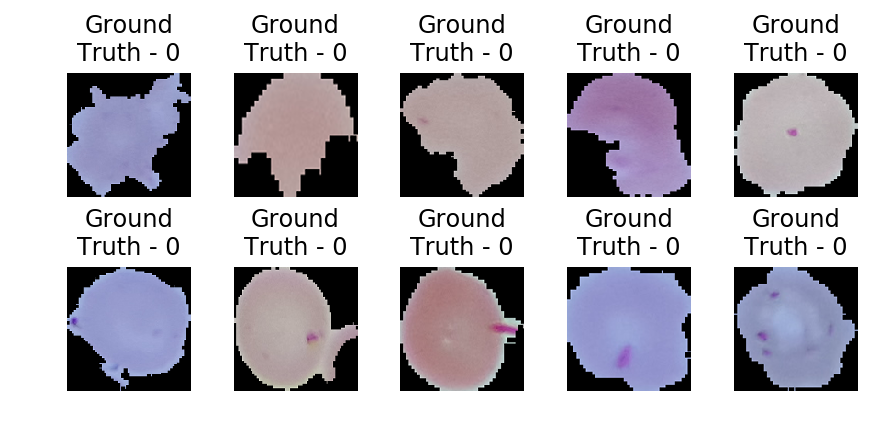

In [104]:
plt.figure(figsize=(10, 8))
plt.title("False Positives")
columns = 5
for i, idx in enumerate(false_positives):
    plt.subplot(len(false_positives) / columns + 1, columns, i + 1)
    plt.imshow(X_test[idx])
    img_label = "Ground\nTruth - " + str(y_test[idx])
    plt.title(img_label)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.50, right=0.50)

In [131]:
for idx in enumerate(false_positives):
    print(test_files[idx[1]])

cell_images/Uninfected\C60P21thinF_IMG_20150804_105955_cell_111.png
cell_images/Uninfected\C182P143NThinF_IMG_20151201_171950_cell_93.png
cell_images/Uninfected\C238NThinF_IMG_20151207_114345_cell_46.png
cell_images/Uninfected\C95P56ThinF_IMG_20150821_171530_cell_36.png
cell_images/Uninfected\C172P133ThinF_IMG_20151119_155156_cell_142.png
cell_images/Uninfected\C139P100ThinF_IMG_20151005_183521_cell_58.png
cell_images/Uninfected\C214ThinF_IMG_20151106_131748_cell_189.png
cell_images/Uninfected\C152P113ThinF_IMG_20151115_124032_cell_171.png
cell_images/Uninfected\C138P99ThinF_IMG_20151005_173453_cell_37.png
cell_images/Uninfected\C39P4thinF_original_IMG_20150622_111206_cell_22.png


    As observed, all the false negative predictions belong to the uninfected category and there are 
    some samples that clearly show the presence of the parasite in the cells however, the are categorized under uninfected.
    This can be accounted to data labeling error.

<a name='5.2'></a>
### 5.2 False Negatives

In [115]:
false_negative_idx = [idx for idx, item in enumerate(false_preds) if y_preds_binary[item] == 0]

false_negative = []
for i in range(len(false_negative_idx)):
    false_negative.append(false_preds[false_negative_idx[i]])
    
print(false_negative)

[123, 445, 473, 717, 1368, 1579, 1706, 1858, 2208, 2722, 3098, 3494, 3517, 3715, 3951, 4088]


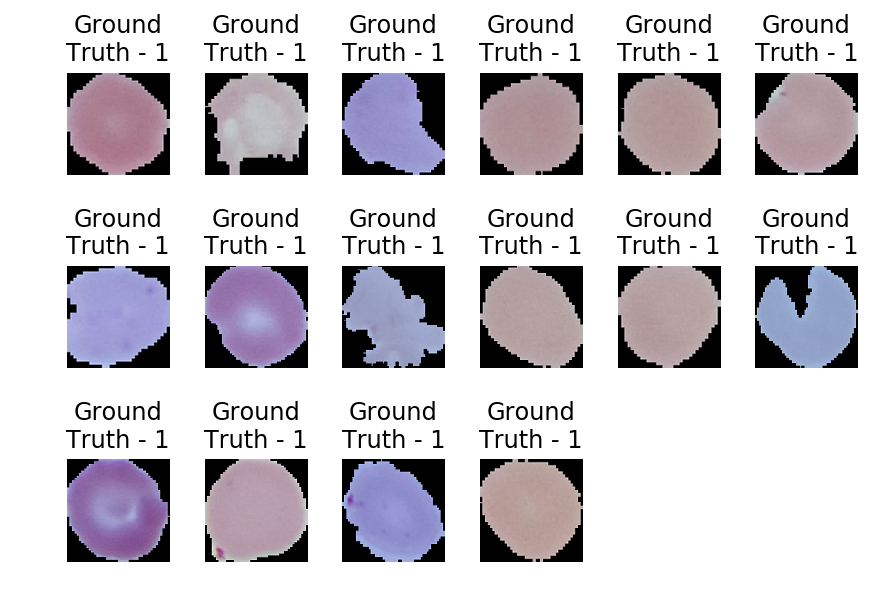

In [113]:
plt.figure(figsize=(12, 8))
plt.title("False Negatives")
columns = 6
for i, idx in enumerate(false_negative):
    plt.subplot(len(false_negative) / columns + 1, columns, i + 1)
    plt.imshow(X_test[idx])
    img_label = "Ground\nTruth - " + str(y_test[idx])
    plt.title(img_label)
    plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(top=0.50, right=0.50)

In [130]:
for idx in enumerate(false_negative):
    print(test_files[idx[1]])

cell_images/Parasitized\C164P125ThinF_IMG_20151116_120135_cell_140.png
cell_images/Parasitized\C176P137NThinF_IMG_20151201_121808_cell_116.png
cell_images/Parasitized\C99P60ThinF_IMG_20150918_141520_cell_108.png
cell_images/Parasitized\C182P143NThinF_IMG_20151201_171905_cell_153.png
cell_images/Parasitized\C182P143NThinF_IMG_20151201_172216_cell_152.png
cell_images/Parasitized\C167P128ReThinF_IMG_20151201_105354_cell_228.png
cell_images/Parasitized\C62P23N_ThinF_IMG_20150818_133211_cell_197.png
cell_images/Parasitized\C116P77ThinF_IMG_20150930_172112_cell_101.png
cell_images/Parasitized\C51AP12thinF_IMG_20150724_154243_cell_129.png
cell_images/Parasitized\C182P143NThinF_IMG_20151201_172257_cell_153.png
cell_images/Parasitized\C182P143NThinF_IMG_20151201_172216_cell_146.png
cell_images/Parasitized\C49P10thinF_IMG_20150724_102330_cell_225.png
cell_images/Parasitized\C116P77ThinF_IMG_20150930_171219_cell_85.png
cell_images/Parasitized\C175P136NThinF_IMG_20151127_142009_cell_242.png
cell_i

    As observed, all the false negative predictions belong to the parasitized category and  there are 
    some samples that do not show any presence of the parasite in the cells however, the are labeled as parasitized. This 
    can be accounted to data labeling error.

<a name='7'></a>
## 6. Summary

<a name='7.1'></a>
### 6.1 Snapshot Ensemble

- Snapshots are recorded after the end of every 10th cycle which is a local minima point.
- The learning rate follows a cosine pattern using the concept of cosine annealing.
- To start recording a new snapshot, training is restarted by increasing the learning rate such that the model escapes the current local minima.
- As the training progresses and the model is learning, the snapshots become better in performing the required job.
- Once all the snapshots are recorded, ensembles are created using different combinations of the snapshots.
- The last 'm' snapshots are always considered while creating the ensemble since the later recorded snapshots are more accurate than the earlier recorded ones for performing the job.
- Snapshot ensembling is an efficient way for creating high performace ensembles which not only saves on the training time but also does so with a limited training budget in terms of hardware resources and computational requirements.

<a name='7.2'></a>
### 6.2 False Case Analysis

All the models experimented in this study have some amount of false predictions as false positives and false negatives. An analysis was done to check on these false predictions for a model to examine the possible reason for such error. The Snapshot Ensembled [4,5] was chosen for this analysis. The confusion matrix of this model looks like 
[[2051, 10] [16, 2057]]. The model has a total of 26 false predictions with 10 false positives and 16 false negatives. 

In the case of false positives ([5.1](#5.1)), some of the images clearly indicate the presence of the parasite after staining. However, they are mislabeled as 0 (uninfected). Similarly, in the case of false negatives ([5.2](#5.2)), images do not show any presence of parasite after staining still they have a label 1 (parasitized). This indicates there is some amount of data labeling error. 

Labeling is mostly done manually by human experts which is prone to error. Such errors could possibly have some negative impact during the training phase causing the model to learn some erroneous representations and consequently decrease the overall performance of models resulting in false predictions. Correcting the labels and re-training the models could improve the model classification rates. 